## Inititalize

Run install_libraries notebook first.

General

In [2]:
import pandas as pd
import numpy as np
from dask.distributed import Client, as_completed
from dask import delayed
import dask.dataframe as dd
import dask, ast, itertools
import dask_ml.model_selection as dcv

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
import datetime as dt
import boto3, yaml
from sagemaker import get_execution_role
from datetime import timedelta

from scipy.stats import expon

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct, PairwiseKernel
from sklearn.preprocessing import StandardScaler, label_binarize, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
import itertools
from sklearn.metrics import roc_curve, auc, precision_score, f1_score, recall_score, average_precision_score, precision_recall_curve, confusion_matrix, classification_report

import sys,os, joblib
util_path = os.path.abspath(os.path.join(os.path.pardir, '../sasse-polygon-process/lib'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)
    
from util import evaluate, feature_selection, plot_confusion_matrix, prec_rec_curve, feature_importance
from util import plot_class_hist, read_data, cv, gridcv, plot_roc
from config import read_options
from viz import Viz
from filehandler import FileHandler

sns.set()
sns.set_style("whitegrid")
%matplotlib inline

MLP

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
import talos

In [3]:
import tensorflow as tf
import keras
from keras import layers
from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping
import talos

VAE

In [6]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

Following snippet is used to get forest columns from database (inserted into ../cnf/rfc.ini)

In [4]:
import sklearn
print(dask.__version__)
print(pd.__version__)
print(sklearn.__version__)
def get_version():
    return {'sklearn': sklearn.__version__, 'joblib': joblib.__version__}


2.12.0
1.0.3
0.23.1


In [139]:
client = Client('Dask-Scheduler.local-dask:8786')
client.get_versions(check=True)
client

Client Scheduler: tcp://Dask-Scheduler.local-dask:8786 Dashboard: http://Dask-Scheduler.local-dask:8787/status,Cluster Workers: 20 Cores: 40 Memory: 171.80 GB


In [6]:
client.submit(get_version).result()

{'sklearn': '0.23.1', 'joblib': '0.15.1'}

In [7]:
joblib.__version__

'0.15.1'

In [16]:
client.restart()

Client Scheduler: tcp://Dask-Scheduler.local-dask:8786 Dashboard: http://Dask-Scheduler.local-dask:8787/status,Cluster Workers: 25 Cores: 50 Memory: 214.75 GB


In [97]:
class Options(): pass

options = Options()
options.config_filename = '../cnf/rfc.ini'
options.config_name = 'forest'
read_options(options)

options_thin = Options()
options_thin.config_filename = '../cnf/rfc.ini'
options_thin.config_name = 'thin'
read_options(options_thin)

In [98]:
num_classes=3

## Loiste-JSE

### Get data

In [185]:
name='loiste_jse_recent_15'
name_random = 'loiste_jse_random_15'

name_20='loiste_jse_recent_20'
name_20_random = 'loiste_jse_random_20'

X_train, y_train, X_test, y_test = read_data('../data/{}_all_train.csv'.format(name), 
                                             '../data/{}_all_test.csv'.format(name), 
                                             options)
X_res, y_res, _, _ = read_data('../data/{}_all_res.csv'.format(name), None, options)

X_train_20, y_train_20, X_test_20, y_test_20 = read_data('../data/{}_all_train.csv'.format(name_20), 
                                                         '../data/{}_all_test.csv'.format(name_20), 
                                                         options)
X_res_20, y_res_20, _, _ = read_data('../data/{}_all_res.csv'.format(name_20), None, options)

X_train_random_20, y_train_random_20, X_test_random_20, y_test_random_20 = read_data('../data/{}_all_train.csv'.format(name_20_random), 
                                                         '../data/{}_all_test.csv'.format(name_20_random), 
                                                         options)



X_train_random, y_train_random, X_test_random, y_test_random = read_data('../data/{}_all_train.csv'.format(name_random), 
                                                                         '../data/{}_all_test.csv'.format(name_random), 
                                                                         options)
X_res_random, y_res_random, _, _ = read_data('../data/{}_all_res.csv'.format(name_random), 
                                             None,
                                             options)
X_train_thin_random, y_train_thin_random, X_test_thin_random, y_test_thin_random = read_data('../data/{}_thin_train.csv'.format(name_random), 
                                                                                             '../data/{}_thin_test.csv'.format(name_random),
                                                                                             options_thin)
X_train_thin_random_20, y_train_thin_random_20, X_test_thin_random_20, y_test_thin_random_20 = read_data('../data/{}_thin_train.csv'.format(name_20_random), 
                                                                                             '../data/{}_thin_test.csv'.format(name_20_random),
                                                                                             options_thin)

X_res_thin_random, y_res_thin_random, _, _ = read_data('../data/{}_thin_res.csv'.format(name_random), 
                                                       None, 
                                                       options_thin)
X_res_thin_random_20, y_res_thin_random_20, _, _ = read_data('../data/{}_thin_res.csv'.format(name_20_random), 
                                                       None, 
                                                       options_thin)


X_train_thin, y_train_thin, X_test_thin, y_test_thin = read_data('../data/{}_thin_train.csv'.format(name), '../data/{}_thin_test.csv'.format(name), options_thin)
X_res_thin, y_res_thin, _, _ = read_data('../data/{}_thin_res.csv'.format(name), None, options_thin)

X_train_small, y_train_small, X_test_small, y_test_small = read_data('../data/{}_small_train.csv'.format(name), '../data/{}_all_test.csv'.format(name), options)
X_res_small, y_res_small = SMOTE().fit_resample(X_train, y_train)

Train data shape: (4923, 60)
Test data shape: (1235, 60)
Train data shape: (13545, 60)
Train data shape: (259, 60)
Test data shape: (69, 60)
Train data shape: (687, 60)
Train data shape: (274, 60)
Test data shape: (54, 60)
Train data shape: (5132, 60)
Test data shape: (1026, 60)
Train data shape: (14172, 60)
Train data shape: (5132, 35)
Test data shape: (1026, 35)
Train data shape: (274, 35)
Test data shape: (54, 35)
Train data shape: (14172, 35)
Train data shape: (732, 35)
Train data shape: (4923, 35)
Test data shape: (1235, 35)
Train data shape: (13545, 35)
Train data shape: (1409, 60)
Test data shape: (1235, 60)


Double check that we don't have duplicate values

In [175]:
dfdup = pd.concat([X_train, X_test])
assert len(dfdup[(dfdup.duplicated())]) == 0
dfdup = pd.concat([X_train_thin, X_test_thin])
assert len(dfdup[(dfdup.duplicated())]) == 0
dfdup = pd.concat([X_train_thin.loc[:, options_thin.feature_params], X_test.loc[:,options_thin.feature_params]])
assert len(dfdup[(dfdup.duplicated())]) == 0
dfdup = pd.concat([X_res, X_test])
assert len(dfdup[(dfdup.duplicated())]) == 0
dfdup = pd.concat([X_res_thin, X_test])
assert len(dfdup[(dfdup.duplicated())]) == 0
dfdup = pd.concat([X_train_small, X_test])
assert len(dfdup[(dfdup.duplicated())]) == 0
dfdup = pd.concat([X_train_random, X_test_random])
assert len(dfdup[(dfdup.duplicated())]) == 0

#### Visualise

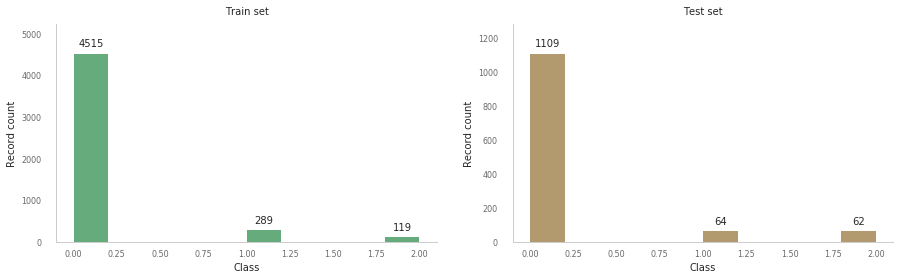

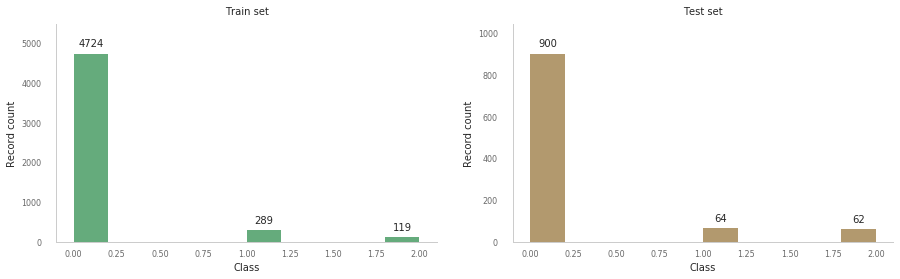

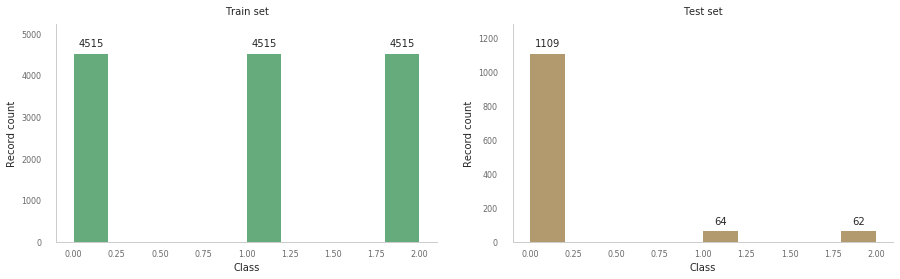

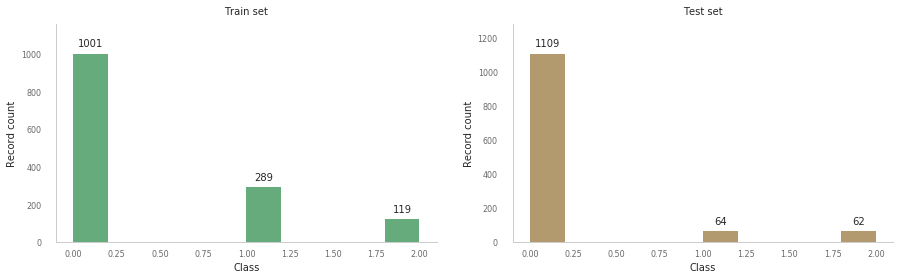

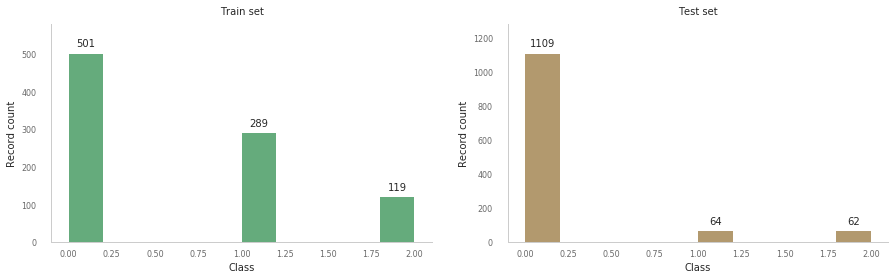

In [176]:
plot_class_hist(pd.DataFrame(y_train, columns=['class']), pd.DataFrame(y_test, columns=['class']))
plot_class_hist(pd.DataFrame(y_train_random, columns=['class']), pd.DataFrame(y_test_random, columns=['class']))
plot_class_hist(pd.DataFrame(y_res, columns=['class']), pd.DataFrame(y_test, columns=['class']))
plot_class_hist(pd.DataFrame(y_train_small, columns=['class']), pd.DataFrame(y_test_small, columns=['class']))
plot_class_hist(pd.DataFrame(y_train_tiny, columns=['class']), pd.DataFrame(y_test_tiny, columns=['class']))

### RFC

#### All features

In [84]:
model = RandomForestClassifier(n_jobs=-1, class_weight="balanced")

with joblib.parallel_backend('dask'):
    model.fit(X_train, y_train)

Visualise trained model performance

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1109
           1       0.00      0.00      0.00        64
           2       0.00      0.00      0.00        62

    accuracy                           0.90      1235
   macro avg       0.30      0.33      0.32      1235
weighted avg       0.81      0.90      0.85      1235



<Figure size 432x288 with 0 Axes>

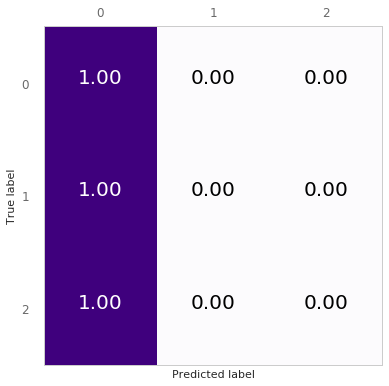

In [85]:
y_pred = model.predict(X_test)
plot_confusion_matrix(y_test, y_pred, range(0,num_classes), normalize=True, cmap=plt.cm.Purples)

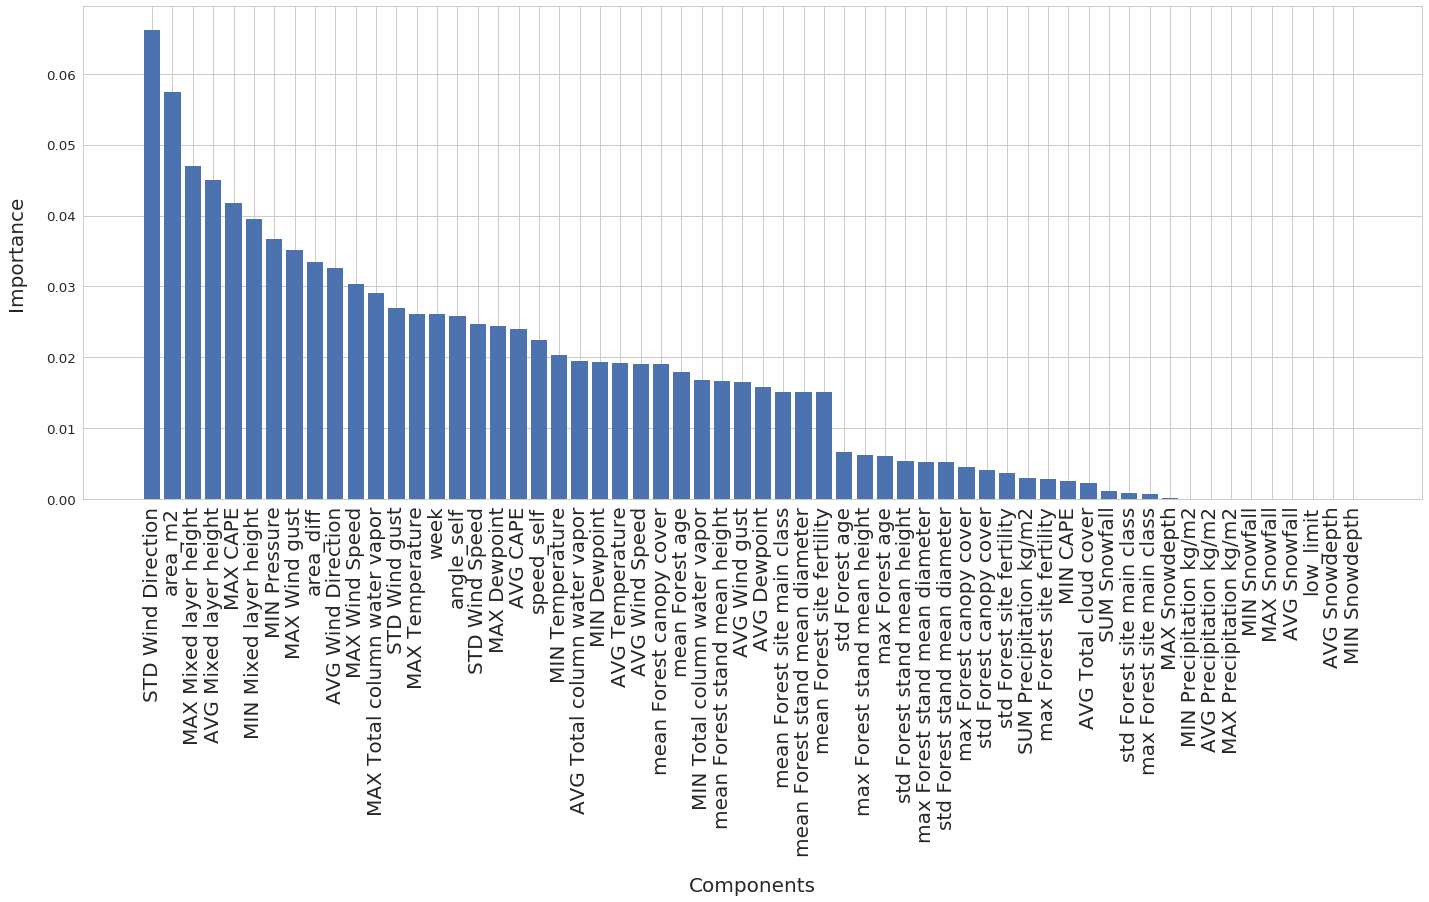

In [15]:
# Sort feature importances in descending order and rearrange feature names accordingly
indices = np.argsort(model.feature_importances_)[::-1]
names = [options.feature_params[i] for i in indices]
importances = model.feature_importances_[indices]
feature_importance(importances, names)

Some notes: 
1. The only precipitation feature is SUM precipitation kg/m2, which also have very little importance. 
2. Only mean aggregations of forest parameters are important

#### SMOTE

In [53]:
model_res = RandomForestClassifier(n_jobs=-1)

with joblib.parallel_backend('dask'):
    model_res.fit(X_res, y_res)

# Sort feature importances in descending order and rearrange feature names accordingly
indices_res = np.argsort(model_res.feature_importances_)[::1]
names_res = [options.feature_params[i] for i in indices_res]

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       460
           1       0.09      0.11      0.10        45
           2       0.71      0.19      0.29        54

    accuracy                           0.78       559
   macro avg       0.56      0.41      0.43       559
weighted avg       0.78      0.78      0.77       559



<Figure size 432x288 with 0 Axes>

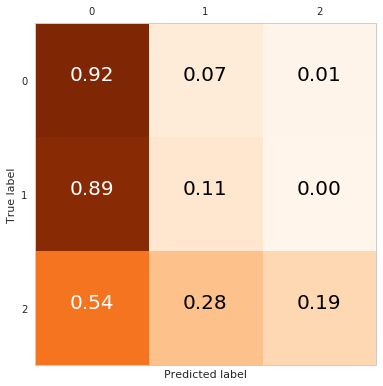

In [54]:
y_pred_res = model_res.predict(X_test)
plot_confusion_matrix(y_test, y_pred_res, range(0,num_classes), normalize=True, cmap=plt.cm.Oranges)

#### SMOTE | threshold 20 m/s

In [187]:
model_res = RandomForestClassifier(n_jobs=-1)

#with joblib.parallel_backend('dask'):
model_res.fit(X_res_20, y_res_20)

# Sort feature importances in descending order and rearrange feature names accordingly
indices_res = np.argsort(model_res.feature_importances_)[::1]
names_res = [options.feature_params[i] for i in indices_res]

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        53
           1       0.00      0.00      0.00         6
           2       1.00      0.40      0.57        10

    accuracy                           0.83        69
   macro avg       0.61      0.47      0.49        69
weighted avg       0.78      0.83      0.78        69



<Figure size 432x288 with 0 Axes>

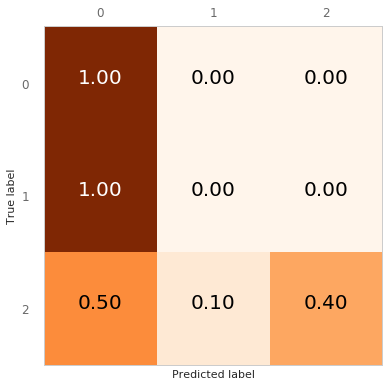

In [188]:
y_pred_res = model_res.predict(X_test_20)
plot_confusion_matrix(y_test_20, y_pred_res, range(0,num_classes), normalize=True, cmap=plt.cm.Oranges)

#### Randomised CV search for RFC

In [92]:
class_weights = []
for i in np.arange(0,1,.3):
    for j in np.arange(0, 1-i, .1):
        k = 1 - i - j 
        class_weights.append({0: i, 1: j, 2: k})

param_grid_rfc = {"n_estimators": [10, 100, 150, 200, 250, 500, 800],
                  "max_depth": [3, 10, 20, 50, None],
                  "max_features": ["auto", "sqrt", "log2", None],
                  "min_samples_split": [2,5,10,50],
                  "min_samples_leaf": [1, 2, 4, 10, 20],
                  "bootstrap": [True, False],
                  "class_weight": class_weights}

param_grid_rfc_smote = {"n_estimators": [10, 100, 150, 200, 250, 500, 800],
                        "max_depth": [3, 10, 20, 50, None],
                        "max_features": ["auto", "sqrt", "log2", None],
                        "min_samples_split": [2,5,10,50],
                        "min_samples_leaf": [1, 2, 4, 10, 20],
                        "bootstrap": [True, False]}

In [58]:
model_res, cv_results = cv(RandomForestClassifier(n_jobs=-1), param_grid_rfc, X_res, y_res, n_iter=50)

..performing cv search...


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classifier=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


                                              params  mean_fit_time  \
0  {'n_estimators': 800, 'min_samples_split': 10,...     102.381220   
1  {'n_estimators': 100, 'min_samples_split': 2, ...      18.092718   
2  {'n_estimators': 10, 'min_samples_split': 10, ...       1.692274   
3  {'n_estimators': 500, 'min_samples_split': 5, ...      62.285159   
4  {'n_estimators': 100, 'min_samples_split': 2, ...     101.019695   

   std_fit_time  mean_score_time  std_score_time  split0_test_f1_macro  \
0      1.087870         2.171732        0.143963              0.944465   
1      0.717993         0.325984        0.045632              0.932365   
2      0.153294         0.034942        0.020419              0.929876   
3      2.368627         1.279447        0.075564              0.941938   
4      1.446904         0.286901        0.063039              0.922545   

   split1_test_f1_macro  split2_test_f1_macro  split3_test_f1_macro  \
0              0.971543              0.970192            

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       460
           1       0.15      0.13      0.14        45
           2       0.59      0.19      0.28        54

    accuracy                           0.80       559
   macro avg       0.53      0.42      0.44       559
weighted avg       0.77      0.80      0.77       559



<Figure size 432x288 with 0 Axes>

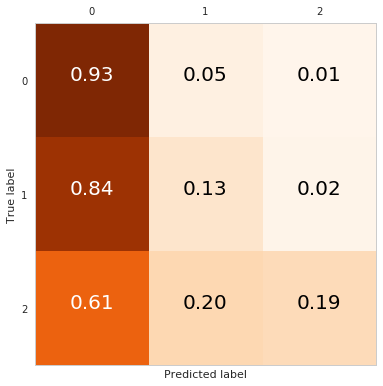

In [59]:
y_pred_res = model_res.predict(X_test)
plot_confusion_matrix(y_test, y_pred_res, range(0,num_classes), normalize=True, cmap=plt.cm.Oranges)

#### Small dataset with all params

In [60]:
model_small, cv_results = cv(RandomForestClassifier(n_jobs=-1), param_grid_rfc, X_train_small, y_train_small, n_iter=50)

..performing cv search...


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classifier=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


                                              params  mean_fit_time  \
0  {'n_estimators': 200, 'min_samples_split': 5, ...       2.425712   
1  {'n_estimators': 10, 'min_samples_split': 50, ...       0.212308   
2  {'n_estimators': 250, 'min_samples_split': 2, ...      18.243273   
3  {'n_estimators': 500, 'min_samples_split': 5, ...      31.823559   
4  {'n_estimators': 100, 'min_samples_split': 10,...       1.351787   

   std_fit_time  mean_score_time  std_score_time  split0_test_f1_macro  \
0      0.145319         0.186701        0.035330              0.367838   
1      0.047520         0.031811        0.026641              0.377459   
2      0.870499         0.201479        0.054642              0.361099   
3      2.515858         0.408401        0.021340              0.313838   
4      0.145399         0.088631        0.019051              0.356373   

   split1_test_f1_macro  split2_test_f1_macro  split3_test_f1_macro  \
0              0.408682              0.352087            

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       460
           1       0.11      0.22      0.14        45
           2       0.46      0.20      0.28        54

    accuracy                           0.72       559
   macro avg       0.48      0.42      0.43       559
weighted avg       0.77      0.72      0.74       559



<Figure size 432x288 with 0 Axes>

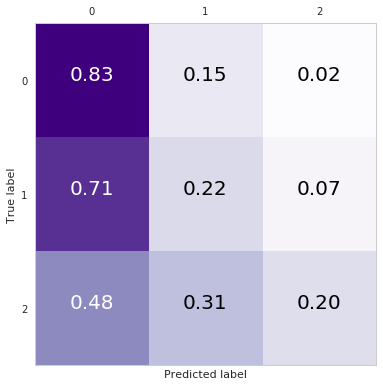

In [61]:
y_pred = model_small.predict(X_test)
plot_confusion_matrix(y_test, y_pred, range(0,num_classes), normalize=True, cmap=plt.cm.Purples)

#### Thin setup (few parameters)

In [102]:
model_rfc_thin, cv_results = cv(RandomForestClassifier(n_jobs=-1), param_grid_rfc, X_train_thin, y_train_thin, n_iter=100)

..performing cv search...
                                              params  mean_fit_time  \
0  {'n_estimators': 150, 'min_samples_split': 10,...      34.530661   
1  {'n_estimators': 250, 'min_samples_split': 2, ...      56.047246   
2  {'n_estimators': 10, 'min_samples_split': 50, ...       1.637000   
3  {'n_estimators': 200, 'min_samples_split': 2, ...      29.396109   
4  {'n_estimators': 10, 'min_samples_split': 2, '...       0.566354   

   std_fit_time  mean_score_time  std_score_time  split0_test_f1_macro  \
0      1.062573         0.176750        0.051109              0.336400   
1      3.653592         0.300557        0.018452              0.316560   
2      0.150546         0.021388        0.019404              0.365700   
3      4.441337         0.262753        0.044111              0.330677   
4      0.044649         0.023710        0.021708              0.338598   

   split1_test_f1_macro  split2_test_f1_macro  split3_test_f1_macro  \
0              0.401509        

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1109
           1       0.10      0.17      0.13        64
           2       0.29      0.18      0.22        62

    accuracy                           0.83      1235
   macro avg       0.44      0.42      0.42      1235
weighted avg       0.84      0.83      0.84      1235

Average precision score, micro-averaged over all classes: 0.82


<Figure size 432x288 with 0 Axes>

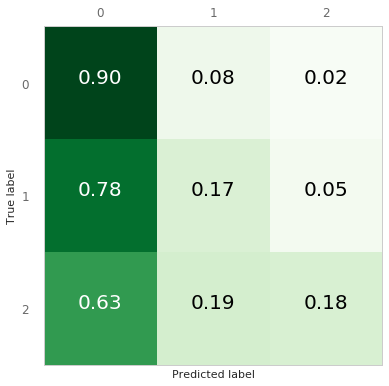

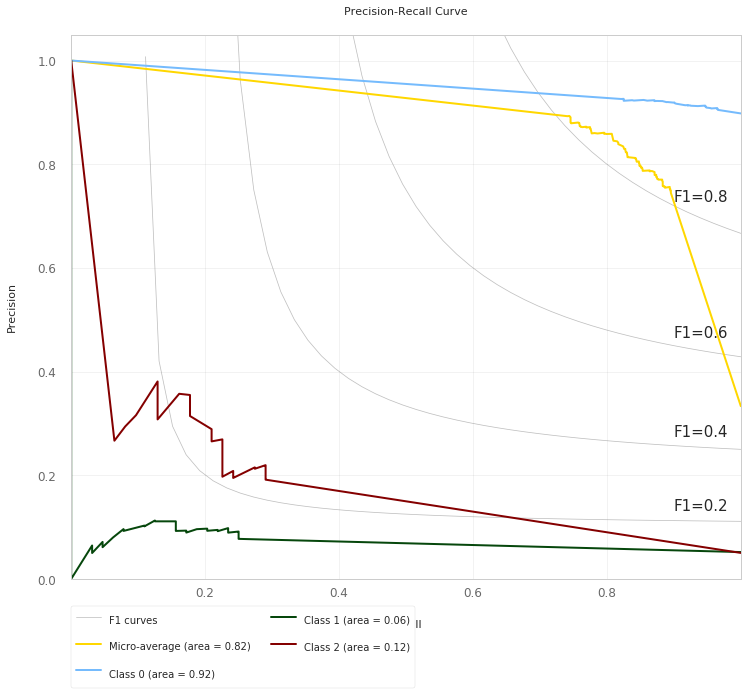

In [103]:
y_pred_proba = model_rfc_thin.predict_proba(X_test_thin)
y_pred = model_rfc_thin.predict(X_test_thin)
plot_confusion_matrix(y_test_thin, y_pred, range(0,num_classes), normalize=True, cmap=plt.cm.Greens)
prec_rec_curve(y_test_thin, y_pred_proba, num_classes, fontsize=15)

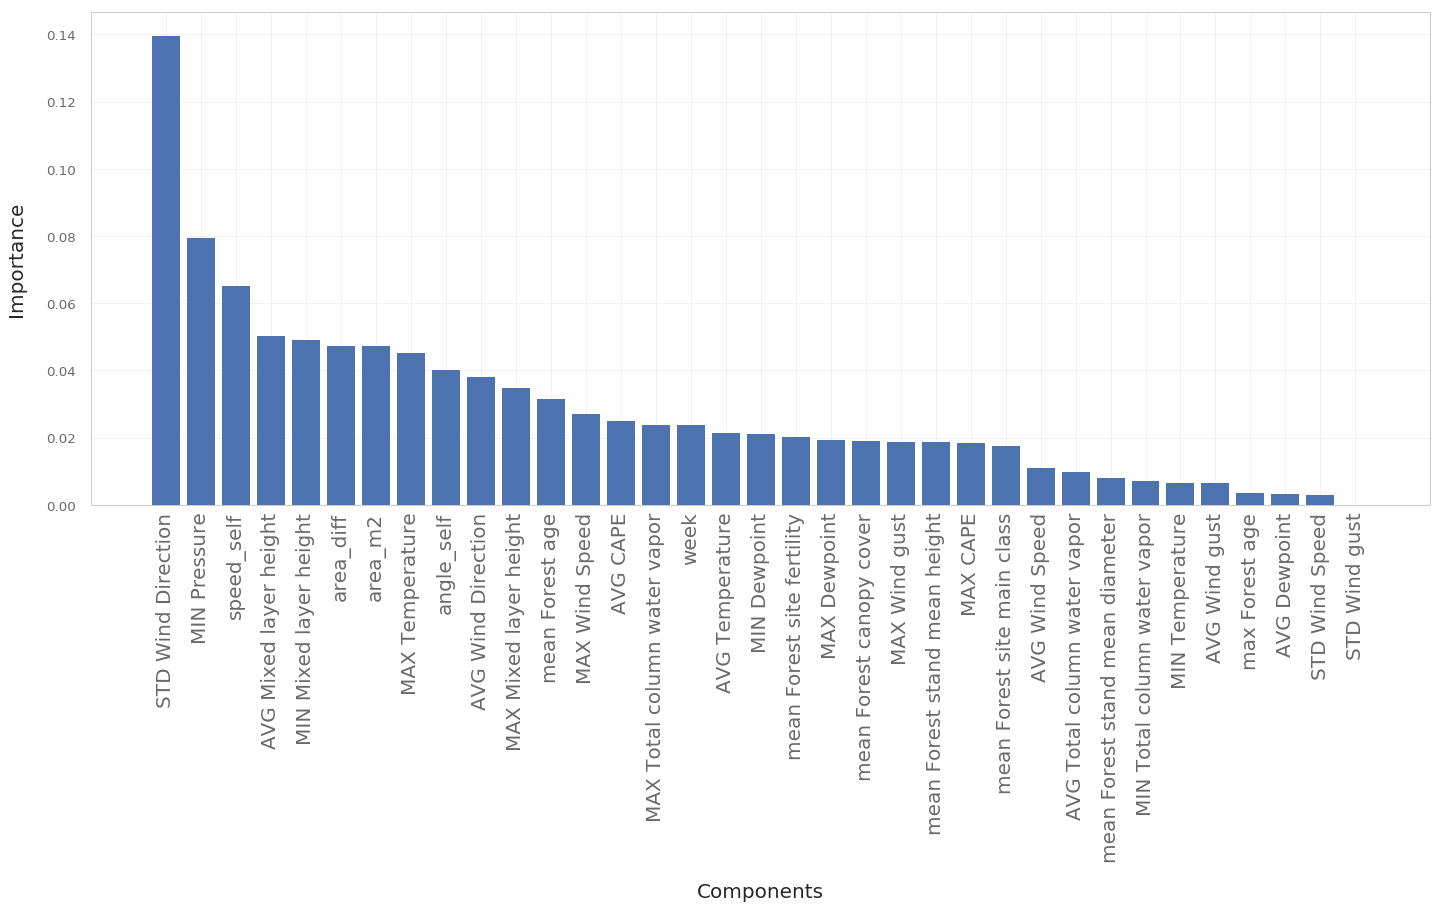

In [104]:
# Sort feature importances in descending order and rearrange feature names accordingly
indices = np.argsort(model_rfc_thin.feature_importances_)[::-1]
names = [options_thin.feature_params[i] for i in indices]
importances = model_rfc_thin.feature_importances_[indices]
feature_importance(importances, names)

#### Thin setup (few parameters) with SMOTE

In [95]:
model_res_thin, cv_results = cv(RandomForestClassifier(n_jobs=-1), param_grid_rfc, X_res_thin, y_res_thin, n_iter=100)

..performing cv search...
                                              params  mean_fit_time  \
0  {'n_estimators': 150, 'min_samples_split': 2, ...      21.245978   
1  {'n_estimators': 200, 'min_samples_split': 2, ...      30.213600   
2  {'n_estimators': 500, 'min_samples_split': 10,...      43.913031   
3  {'n_estimators': 100, 'min_samples_split': 10,...       9.011707   
4  {'n_estimators': 250, 'min_samples_split': 10,...      30.473309   

   std_fit_time  mean_score_time  std_score_time  split0_test_f1_macro  \
0      1.308676         0.391823        0.066817              0.949547   
1      1.598963         0.398709        0.059464              0.944278   
2      2.216454         1.275628        0.036503              0.940467   
3      0.756483         0.258320        0.042475              0.926713   
4      0.667023         0.567196        0.059934              0.915435   

   split1_test_f1_macro  split2_test_f1_macro  split3_test_f1_macro  \
0              0.962168        

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1109
           1       0.14      0.09      0.11        64
           2       0.54      0.11      0.19        62

    accuracy                           0.89      1235
   macro avg       0.53      0.39      0.41      1235
weighted avg       0.86      0.89      0.86      1235



<Figure size 432x288 with 0 Axes>

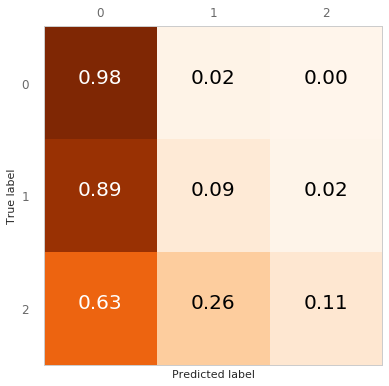

In [96]:
y_pred_res_thin = model_res_thin.predict(X_test_thin)
plot_confusion_matrix(y_test_thin, y_pred_res_thin, range(0,num_classes), normalize=True, cmap=plt.cm.Oranges)

### SVC

#### Train model with all features

In [67]:
model_svc = SVC(class_weight="balanced")

with joblib.parallel_backend('dask'):
    model_svc.fit(X_train, y_train)

Visualise trained model performance

              precision    recall  f1-score   support

           0       0.94      0.66      0.78       460
           1       0.14      0.49      0.21        45
           2       0.30      0.43      0.35        54

    accuracy                           0.62       559
   macro avg       0.46      0.53      0.45       559
weighted avg       0.82      0.62      0.69       559



<Figure size 432x288 with 0 Axes>

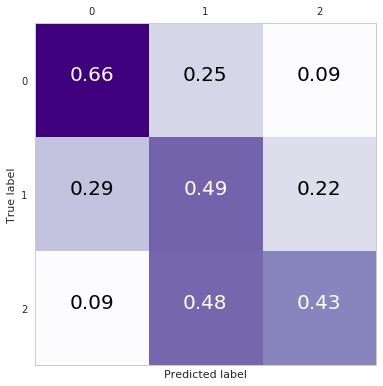

In [68]:
y_pred_svc = model_svc.predict(X_test)
plot_confusion_matrix(y_test, y_pred_svc, range(0,num_classes), normalize=True, cmap=plt.cm.Purples)

#### Train with SMOTE

In [69]:
model_svc_res = SVC()

with joblib.parallel_backend('dask'):
    model_svc_res.fit(X_res, y_res)    

              precision    recall  f1-score   support

           0       0.92      0.79      0.85       460
           1       0.17      0.40      0.24        45
           2       0.34      0.39      0.36        54

    accuracy                           0.72       559
   macro avg       0.48      0.53      0.48       559
weighted avg       0.80      0.72      0.75       559



<Figure size 432x288 with 0 Axes>

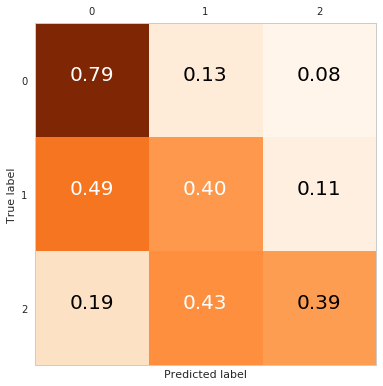

In [70]:
y_pred = model_svc_res.predict(X_test)
plot_confusion_matrix(y_test, y_pred, range(0,num_classes), normalize=True, cmap=plt.cm.Oranges)

#### Train with thin SMOTE

Fixed testset

In [163]:
model_svc_res = SVC()

with joblib.parallel_backend('dask'):
    model_svc_res.fit(X_res_thin, y_res_thin)

              precision    recall  f1-score   support

           0       0.94      0.79      0.86      1109
           1       0.08      0.28      0.13        64
           2       0.26      0.37      0.30        62

    accuracy                           0.74      1235
   macro avg       0.43      0.48      0.43      1235
weighted avg       0.86      0.74      0.79      1235



<Figure size 432x288 with 0 Axes>

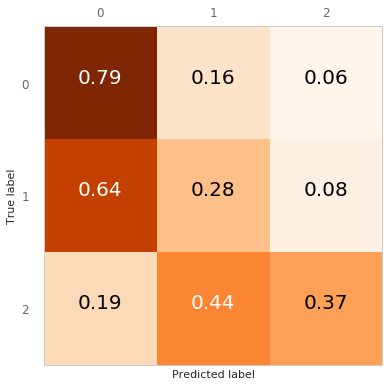

In [164]:
y_pred = model_svc_res.predict(X_test_thin)
plot_confusion_matrix(y_test_thin, y_pred, range(0,num_classes), normalize=True, cmap=plt.cm.Oranges)

Random testset

In [165]:
model_svc_res = SVC()

with joblib.parallel_backend('dask'):
    model_svc_res.fit(X_res_thin_random, y_res_thin_random)

              precision    recall  f1-score   support

           0       0.96      0.80      0.87      1125
           1       0.12      0.38      0.18        71
           2       0.21      0.44      0.29        36

    accuracy                           0.76      1232
   macro avg       0.43      0.54      0.45      1232
weighted avg       0.89      0.76      0.82      1232



<Figure size 432x288 with 0 Axes>

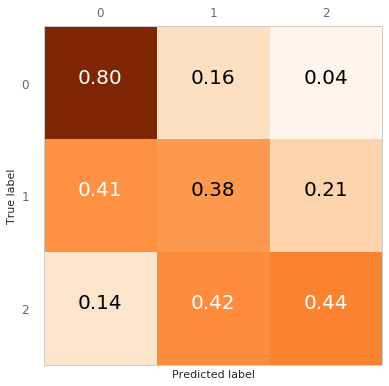

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


In [166]:
y_pred = model_svc_res.predict(X_test_thin_random)
plot_confusion_matrix(y_test_thin_random, y_pred, range(0,num_classes), normalize=True, cmap=plt.cm.Oranges)

#### Random Search CV for SVC -- thin setup

In [105]:
param_grid_svc = {'C': expon(scale=100), 
                  'gamma': expon(scale=.1),
                  'kernel':  ['linear', 'rbf', 'sigmoid'],
                  'coef0': expon(scale=1)
                 }

svc_res, cv_results = cv(SVC(), param_grid_svc, X_train_thin, y_train_thin, n_iter=50)

..performing cv search...
                                              params  mean_fit_time  \
0  {'C': 242.1307513438831, 'coef0': 0.5923743148...       2.356135   
1  {'C': 185.86441189662787, 'coef0': 3.214871398...       1.835303   
2  {'C': 597.8536155404742, 'coef0': 2.2312437332...       3.252263   
3  {'C': 325.54883506920964, 'coef0': 0.316064398...       1.745441   
4  {'C': 81.85530009454031, 'coef0': 2.0228141033...       1.475248   

   std_fit_time  mean_score_time  std_score_time  split0_test_f1_macro  \
0      0.080604         0.190449        0.004705              0.383034   
1      0.097767         0.213493        0.024286              0.385804   
2      0.137656         0.159104        0.023382              0.386845   
3      0.074912         0.194237        0.006853              0.371623   
4      0.063494         0.215940        0.023242              0.370562   

   split1_test_f1_macro  split2_test_f1_macro  split3_test_f1_macro  \
0              0.419030        

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1109
           1       0.10      0.09      0.10        64
           2       0.29      0.23      0.25        62

    accuracy                           0.86      1235
   macro avg       0.44      0.42      0.43      1235
weighted avg       0.85      0.86      0.85      1235



<Figure size 432x288 with 0 Axes>

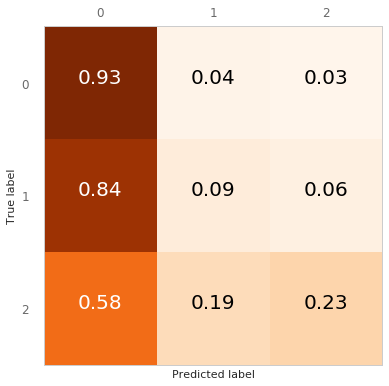

In [106]:
y_pred = svc_res.predict(X_test_thin)
plot_confusion_matrix(y_test_thin, y_pred, range(0,num_classes), normalize=True, cmap=plt.cm.Oranges)

In [ ]:
# Save and visualise results
fname = 'results/random_search_cv_svc_res_thin_results.csv'.format(options.output_path)
fh.df_to_csv(cv_results_svc, fname, fname)

#### DotProduct kernel with SMOTE

In [34]:
#kernel = PairwiseKernel(metric='laplacian') #*  DotProduct()
model_svc_res = SVC(kernel=DotProduct())

with joblib.parallel_backend('dask'):
    model_svc_res.fit(X_res, y_res)

              precision    recall  f1-score   support

           0       0.97      0.60      0.74      1109
           1       0.05      0.27      0.08        64
           2       0.19      0.61      0.30        62

    accuracy                           0.58      1235
   macro avg       0.40      0.49      0.37      1235
weighted avg       0.88      0.58      0.69      1235



<Figure size 432x288 with 0 Axes>

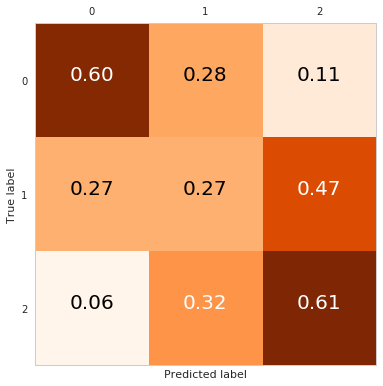

In [35]:
y_pred = model_svc_res.predict(X_test)
plot_confusion_matrix(y_test, y_pred, range(0,num_classes), normalize=True, cmap=plt.cm.Oranges)

With random testset

In [25]:
#kernel = PairwiseKernel(metric='laplacian') #*  DotProduct()
model_svc_res = SVC(kernel=DotProduct() + WhiteKernel())

with joblib.parallel_backend('dask'):
    model_svc_res.fit(X_res_random, y_res_random)

              precision    recall  f1-score   support

           0       0.98      0.65      0.78      1215
           1       0.14      0.52      0.22        91
           2       0.15      0.64      0.24        44

    accuracy                           0.64      1350
   macro avg       0.42      0.60      0.41      1350
weighted avg       0.89      0.64      0.73      1350



<Figure size 432x288 with 0 Axes>

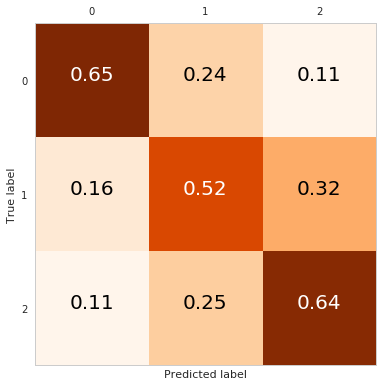

In [26]:
y_pred = model_svc_res.predict(X_test)
plot_confusion_matrix(y_test, y_pred, range(0,num_classes), normalize=True, cmap=plt.cm.Oranges)

#### DotProduct kernel with thin SMOTE

In [111]:
#kernel = PairwiseKernel(metric='laplacian') #*  DotProduct()
model_svc_res = SVC(kernel=DotProduct())

with joblib.parallel_backend('dask'):
    model_svc_res.fit(X_res_thin, y_res_thin)

              precision    recall  f1-score   support

           0       0.97      0.59      0.74      1109
           1       0.07      0.34      0.12        64
           2       0.16      0.63      0.25        62

    accuracy                           0.58      1235
   macro avg       0.40      0.52      0.37      1235
weighted avg       0.88      0.58      0.68      1235



<Figure size 432x288 with 0 Axes>

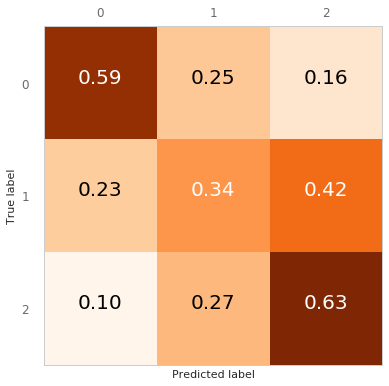

In [113]:
y_pred = model_svc_res.predict(X_test_thin)
plot_confusion_matrix(y_test_thin, y_pred, range(0,num_classes), normalize=True, cmap=plt.cm.Oranges)

With random testset

In [125]:
#kernel = PairwiseKernel(metric='laplacian') #*  DotProduct()
model_svc_res = SVC(kernel=DotProduct() + WhiteKernel())

#with joblib.parallel_backend('dask'):
model_svc_res.fit(X_res_thin_random, y_res_thin_random)

SVC(kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1))

              precision    recall  f1-score   support

           0       0.97      0.65      0.78      1125
           1       0.11      0.45      0.18        71
           2       0.13      0.67      0.22        36

    accuracy                           0.64      1232
   macro avg       0.40      0.59      0.39      1232
weighted avg       0.90      0.64      0.73      1232



<Figure size 432x288 with 0 Axes>

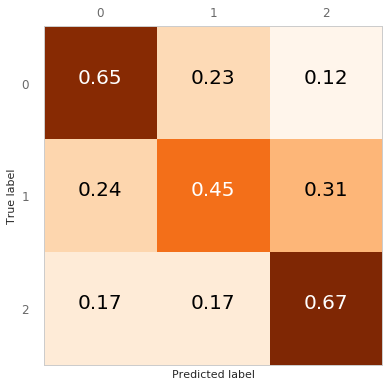

In [126]:
y_pred = model_svc_res.predict(X_test_thin_random)
plot_confusion_matrix(y_test_thin_random, y_pred, range(0,num_classes), normalize=True, cmap=plt.cm.Oranges)

#### DotProduct kernel with SMOTE | 20 m/s threshold

In [183]:
#kernel = PairwiseKernel(metric='laplacian') #*  DotProduct()
model_svc_res = SVC(kernel=DotProduct())

model_svc_res.fit(X_res_thin_random_20, y_res_thin_random_20)

SVC(kernel=DotProduct(sigma_0=1))

              precision    recall  f1-score   support

           0       0.77      0.89      0.83        38
           1       0.20      0.17      0.18         6
           2       0.60      0.30      0.40        10

    accuracy                           0.70        54
   macro avg       0.52      0.45      0.47        54
weighted avg       0.68      0.70      0.68        54



<Figure size 432x288 with 0 Axes>

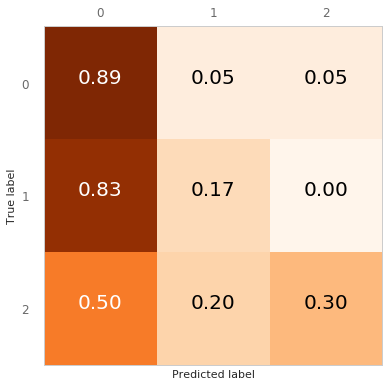

In [186]:
y_pred = model_svc_res.predict(X_test_thin_random_20)
plot_confusion_matrix(y_test_thin_random_20, y_pred, range(0,num_classes), normalize=True, cmap=plt.cm.Oranges)

With random testset

In [25]:
#kernel = PairwiseKernel(metric='laplacian') #*  DotProduct()
model_svc_res = SVC(kernel=DotProduct() + WhiteKernel())

with joblib.parallel_backend('dask'):
    model_svc_res.fit(X_res_random, y_res_random)

              precision    recall  f1-score   support

           0       0.98      0.65      0.78      1215
           1       0.14      0.52      0.22        91
           2       0.15      0.64      0.24        44

    accuracy                           0.64      1350
   macro avg       0.42      0.60      0.41      1350
weighted avg       0.89      0.64      0.73      1350



<Figure size 432x288 with 0 Axes>

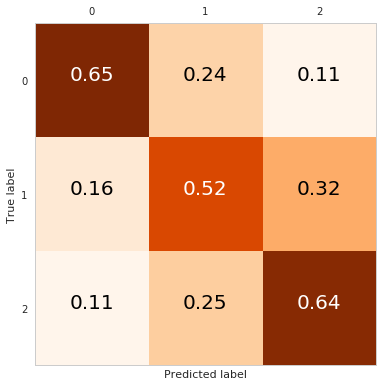

In [26]:
y_pred = model_svc_res.predict(X_test)
plot_confusion_matrix(y_test, y_pred, range(0,num_classes), normalize=True, cmap=plt.cm.Oranges)

### GaussianNB

#### All features

              precision    recall  f1-score   support

           0       0.93      0.60      0.73       460
           1       0.00      0.00      0.00        45
           2       0.18      0.85      0.29        54

    accuracy                           0.57       559
   macro avg       0.37      0.48      0.34       559
weighted avg       0.78      0.57      0.63       559



<Figure size 432x288 with 0 Axes>

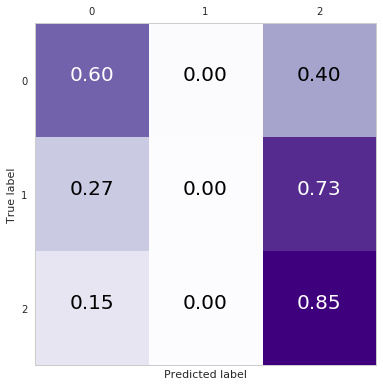

In [85]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
plot_confusion_matrix(y_test, y_pred, range(0,num_classes), normalize=True, cmap=plt.cm.Purples)

In [86]:
print(gnb.class_prior_)

[0.92 0.06 0.02]


#### Random search CV for priors

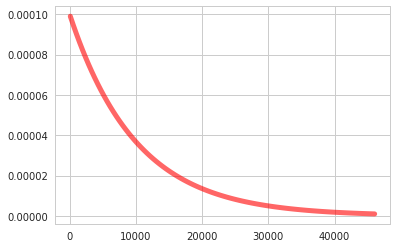

In [87]:
from scipy.stats import expon
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
scale=10000
x = np.linspace(expon.ppf(0.01, scale=scale),
                 expon.ppf(0.99, scale=scale), 100)
ax.plot(x, expon.pdf(x, scale=scale),
        'r-', lw=5, alpha=0.6, label='expon pdf')

In [88]:
priors = []
for i in np.arange(0,1,.05):
    for j in np.arange(0, 1-i, .05):
        k = 1 - i - j 
        priors.append([i, j, k])
                            
param_grid_gnb = {'priors': priors+[None],
                  'var_smoothing': expon(scale=.01)}
#param_grid = {'priors': [None]}

##### All parameters

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


..performing cv search...


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classifier=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


                                              params  mean_fit_time  \
0  {'priors': [0.65, 0.25, 0.09999999999999998], ...       0.009020   
1  {'priors': [0.6000000000000001, 0.300000000000...       0.009154   
2  {'priors': [0.75, 0.05, 0.2], 'var_smoothing':...       0.010652   
3  {'priors': [0.6000000000000001, 0.350000000000...       0.009090   
4  {'priors': [0.55, 0.35000000000000003, 0.09999...       0.009937   

   std_fit_time  mean_score_time  std_score_time  split0_test_f1_macro  \
0      0.001389         0.008222        0.002180              0.351764   
1      0.000784         0.006405        0.001539              0.350761   
2      0.003022         0.005235        0.000215              0.357995   
3      0.000726         0.005110        0.000184              0.358370   
4      0.002272         0.005685        0.000638              0.356797   

   split1_test_f1_macro  split2_test_f1_macro  split3_test_f1_macro  \
0              0.389965              0.353826            

<Figure size 432x288 with 0 Axes>

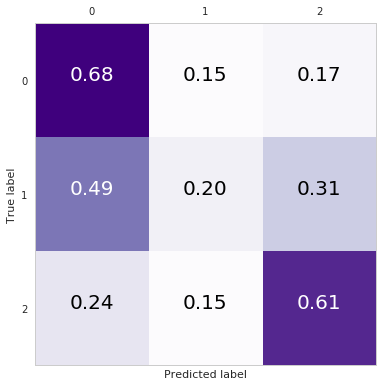

In [89]:
client = Client()
gnb_priors, cv_results = cv(GaussianNB(), param_grid_gnb, X_train, y_train, 100)
y_pred = gnb_priors.predict(X_test)
plot_confusion_matrix(y_test, y_pred, range(0,num_classes), normalize=True, cmap=plt.cm.Purples)

Average precision score, micro-averaged over all classes: 0.70


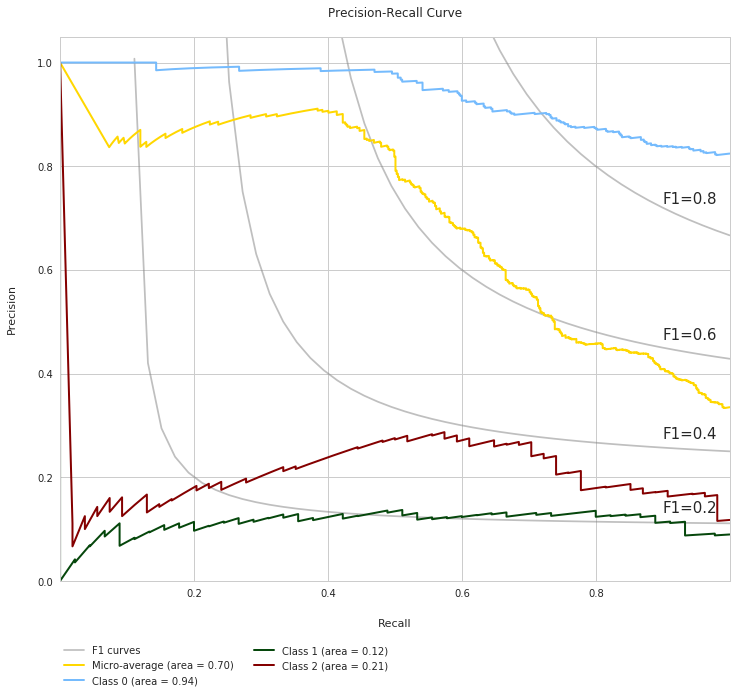

In [90]:
prec_rec_curve(y_test, gnb_priors.predict_proba(X_test), num_classes, fontsize=15)

#### Thin setup

..performing cv search...


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classifier=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


                                              params  mean_fit_time  \
0  {'priors': [0.75, 0.2, 0.04999999999999999], '...       0.005494   
1  {'priors': [0.6000000000000001, 0.350000000000...       0.007234   
2  {'priors': [0.45, 0.5, 0.050000000000000044], ...       0.005021   
3  {'priors': [0.6000000000000001, 0.350000000000...       0.006584   
4  {'priors': [0.65, 0.30000000000000004, 0.04999...       0.005219   

   std_fit_time  mean_score_time  std_score_time  split0_test_f1_macro  \
0      0.001091         0.003932        0.000304              0.370088   
1      0.001536         0.005078        0.001452              0.362499   
2      0.000564         0.004325        0.000596              0.366426   
3      0.001324         0.004965        0.000866              0.361968   
4      0.000570         0.004601        0.001187              0.364333   

   split1_test_f1_macro  split2_test_f1_macro  split3_test_f1_macro  \
0              0.381696              0.386072            

<Figure size 432x288 with 0 Axes>

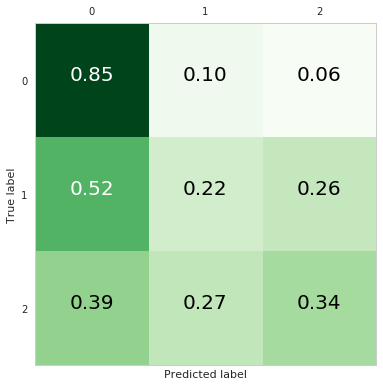

In [91]:
gnb_priors_thin, cv_results = cv(GaussianNB(), param_grid_gnb, X_train_thin, y_train_thin, 100)
y_pred = gnb_priors_thin.predict(X_test_thin)
plot_confusion_matrix(y_test_thin, y_pred, range(0,num_classes), normalize=True, cmap=plt.cm.Greens)

#### SMOTE

..performing cv search...


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classifier=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


                                              params  mean_fit_time  \
0  {'priors': [0.15000000000000002, 0.5, 0.35], '...       0.015187   
1  {'priors': [0.15000000000000002, 0.5, 0.35], '...       0.016161   
2  {'priors': [0.05, 0.6000000000000001, 0.349999...       0.016864   
3  {'priors': [0.05, 0.5, 0.44999999999999996], '...       0.014743   
4  {'priors': [0.1, 0.8, 0.09999999999999998], 'v...       0.014061   

   std_fit_time  mean_score_time  std_score_time  split0_test_f1_macro  \
0      0.002788         0.008288        0.000229              0.587460   
1      0.002311         0.009590        0.002683              0.588544   
2      0.004460         0.008183        0.000493              0.588498   
3      0.001747         0.008740        0.001551              0.588424   
4      0.000591         0.007933        0.000425              0.586631   

   split1_test_f1_macro  split2_test_f1_macro  split3_test_f1_macro  \
0              0.585476              0.584470            

<Figure size 432x288 with 0 Axes>

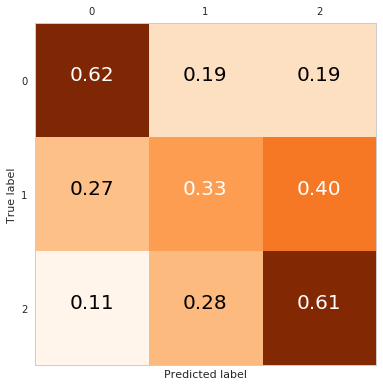

In [92]:
gnb_priors_res, cv_results = cv(GaussianNB(), param_grid_gnb, X_res, y_res, 50)
y_pred = gnb_priors_res.predict(X_test)
plot_confusion_matrix(y_test, y_pred, range(0,num_classes), normalize=True, cmap=plt.cm.Oranges)

#### Thin smote

..performing cv search...


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classifier=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


                                              params  mean_fit_time  \
0  {'priors': [0.2, 0.5, 0.30000000000000004], 'v...       0.007942   
1  {'priors': [0.1, 0.6000000000000001, 0.2999999...       0.007252   
2  {'priors': [0.30000000000000004, 0.45, 0.24999...       0.011172   
3  {'priors': [0.1, 0.4, 0.5], 'var_smoothing': 0...       0.007500   
4  {'priors': [0.15000000000000002, 0.70000000000...       0.009460   

   std_fit_time  mean_score_time  std_score_time  split0_test_f1_macro  \
0      0.001632         0.007469        0.002613              0.652048   
1      0.001476         0.005497        0.000618              0.644440   
2      0.002411         0.005567        0.001212              0.635341   
3      0.000873         0.005706        0.001299              0.639695   
4      0.002651         0.005452        0.001436              0.624532   

   split1_test_f1_macro  split2_test_f1_macro  split3_test_f1_macro  \
0              0.586363              0.579283            

<Figure size 432x288 with 0 Axes>

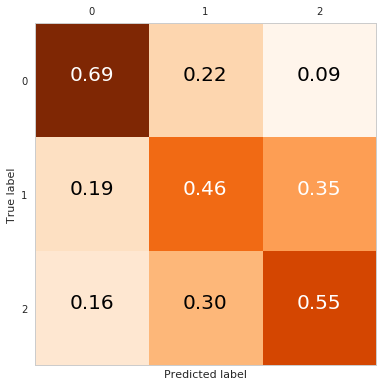

In [93]:
gnb_res_thin, cv_results = cv(GaussianNB(), param_grid_gnb, X_res_thin, y_res_thin, 40)
y_pred_res_thin = gnb_res_thin.predict(X_test_thin)
plot_confusion_matrix(y_test_thin, y_pred_res_thin, range(0,num_classes), normalize=True, cmap=plt.cm.Oranges)

#### With PCA 

With all features in PCA:

              precision    recall  f1-score   support

           0       0.90      0.75      0.82       460
           1       0.12      0.20      0.15        45
           2       0.26      0.48      0.34        54

    accuracy                           0.68       559
   macro avg       0.43      0.48      0.43       559
weighted avg       0.78      0.68      0.72       559



<Figure size 432x288 with 0 Axes>

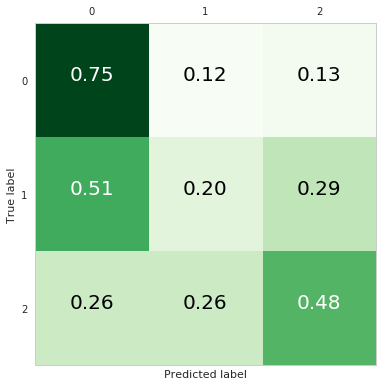

In [94]:
gnb_pca = make_pipeline(PCA(n_components=50), GaussianNB())
gnb_pca.fit(X_train, y_train)
y_pred_gnb_pca = gnb_pca.predict(X_test)
plot_confusion_matrix(y_test, y_pred_gnb_pca, range(0,num_classes), normalize=True, cmap=plt.cm.Greens)

With 15 features in PCA (spoiler alert, using less features makes model to predict always class 0):

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       460
           1       0.17      0.09      0.12        45
           2       0.14      0.07      0.10        54

    accuracy                           0.77       559
   macro avg       0.38      0.36      0.36       559
weighted avg       0.72      0.77      0.74       559



<Figure size 432x288 with 0 Axes>

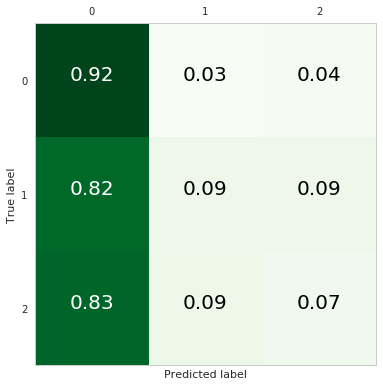

In [95]:
gnb_pca = make_pipeline(PCA(n_components=15), GaussianNB())
gnb_pca.fit(X_train, y_train)
y_pred_gnb_pca = gnb_pca.predict(X_test)
plot_confusion_matrix(y_test, y_pred_gnb_pca, range(0,num_classes), normalize=True, cmap=plt.cm.Greens)

### MLP

In [15]:
# Define a trained and saved model
def train_model(X_train, y_train, X_test, y_test):
    batch_size = 512
    epochs = 500
    dropout_rate = .1    
    
    class_weight = {0: .1,
                    1: .5,
                    2: 1.,
                    3: 1000.}
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
    
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(dropout_rate))    
    model.add(Dense(8, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    
    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(X_test, y_test),
                        callbacks=[es],
                        class_weight=class_weight)
    
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return history, model

In [46]:
# Define a trained and saved model
def m(X_train, y_train, X_test, y_test, params):
    batch_size = params['batch_size']
    epochs = 100
    dropout_rate = params['dropout_rate']
    
    class_weight = params['class_weight']
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=params['patience'])
    
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    model = Sequential()
    model.add(Dense(params['first_neuron'], 
                    activation=params['activation'], 
                    input_shape=(X_train.shape[1],)
                    #kernel_initializer=params['kernel_initializer']
                   ))
    model.add(Dropout(dropout_rate))
    
    for n in params['neurons']:
        if n is not None:
            model.add(Dense(n, activation=params['activation']))
            model.add(Dropout(dropout_rate))

    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss=params['losses'], #keras.losses.categorical_crossentropy,
                  optimizer=params['optimizer'],
                  metrics=['accuracy', talos.utils.metrics.f1score])
    
    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=False,
                        validation_data=(X_test, y_test),
                        callbacks=[es],
                        class_weight=class_weight)
    
    #score = model.evaluate(X_test, y_test, verbose=0)
    #print('Test loss:', score[0])
    #print('Test accuracy:', score[1])
    
    return history, model

In [ ]:
mlp = train_model(X_res.values, y_res, X_test.values, y_test)

In [ ]:
#local_client = Client()
with joblib.parallel_backend('dask'):
    mlp = train_model(X_train.values, y_train, X_test.values, y_test)

              precision    recall  f1-score   support

           0       0.94      0.57      0.71      1478
           1       0.10      0.29      0.14        94
           2       0.04      0.38      0.08        52

    accuracy                           0.54      1624
   macro avg       0.36      0.41      0.31      1624
weighted avg       0.87      0.54      0.66      1624



<Figure size 432x288 with 0 Axes>

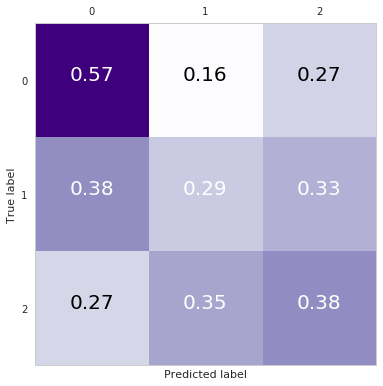

In [11]:
y_pred_mlp_proba = mlp.predict_proba(X_test.values)
y_pred_mlp = np.argmax(y_pred_mlp_proba, axis=1)
plot_confusion_matrix(y_test, y_pred_mlp, range(0,num_classes), normalize=True, cmap=plt.cm.Purples)

#### Thin setup

In [18]:
history, mlp_thin = train_model(X_train_thin.values, y_train_thin, X_test_thin.values, y_test_thin)

Train on 4870 samples, validate on 1624 samples
Epoch 1/500
4870/4870 [==============================] - 0s 100us/sample - loss: 0.1686 - acc: 0.0867 - val_loss: 1.1129 - val_acc: 0.0813
Epoch 2/500
4870/4870 [==============================] - 0s 31us/sample - loss: 0.1686 - acc: 0.0891 - val_loss: 1.1128 - val_acc: 0.0825
Epoch 3/500
4870/4870 [==============================] - 0s 30us/sample - loss: 0.1685 - acc: 0.0840 - val_loss: 1.1127 - val_acc: 0.0825
Epoch 4/500
4870/4870 [==============================] - 0s 31us/sample - loss: 0.1684 - acc: 0.0901 - val_loss: 1.1127 - val_acc: 0.0825
Epoch 5/500
4870/4870 [==============================] - 0s 30us/sample - loss: 0.1685 - acc: 0.0967 - val_loss: 1.1126 - val_acc: 0.0831
Epoch 6/500
4870/4870 [==============================] - 0s 31us/sample - loss: 0.1686 - acc: 0.0871 - val_loss: 1.1125 - val_acc: 0.0831
Epoch 7/500
4870/4870 [==============================] - 0s 30us/sample - loss: 0.1684 - acc: 0.0936 - val_loss: 1.1124 - v

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1478
           1       0.08      0.02      0.03        94
           2       0.04      0.06      0.05        52

    accuracy                           0.86      1624
   macro avg       0.34      0.34      0.34      1624
weighted avg       0.83      0.86      0.84      1624



<Figure size 432x288 with 0 Axes>

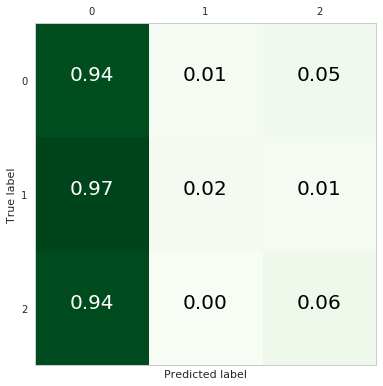

In [21]:
y_pred_mlp_proba = mlp_thin.predict_proba(X_test_thin.values)
y_pred_mlp = np.argmax(y_pred_mlp_proba, axis=1)
plot_confusion_matrix(y_test_thin, y_pred_mlp, range(0,num_classes), normalize=True, cmap=plt.cm.Greens)

#### Thin SMOTE setup

In [22]:
history, mlp_thin_res = train_model(X_res_thin.values, y_res_thin, X_test_thin.values, y_test_thin)

Train on 13299 samples, validate on 1624 samples
Epoch 1/500
13299/13299 [==============================] - 1s 59us/sample - loss: 0.5881 - acc: 0.3375 - val_loss: 1.1292 - val_acc: 0.1866
Epoch 2/500
13299/13299 [==============================] - 0s 30us/sample - loss: 0.5878 - acc: 0.3324 - val_loss: 1.1308 - val_acc: 0.1798
Epoch 3/500
13299/13299 [==============================] - 0s 30us/sample - loss: 0.5867 - acc: 0.3387 - val_loss: 1.1323 - val_acc: 0.1730
Epoch 4/500
13299/13299 [==============================] - 0s 30us/sample - loss: 0.5865 - acc: 0.3407 - val_loss: 1.1337 - val_acc: 0.1626
Epoch 5/500
13299/13299 [==============================] - 0s 31us/sample - loss: 0.5857 - acc: 0.3421 - val_loss: 1.1351 - val_acc: 0.1576
Epoch 6/500
13299/13299 [==============================] - 0s 29us/sample - loss: 0.5851 - acc: 0.3488 - val_loss: 1.1365 - val_acc: 0.1502
Epoch 7/500
13299/13299 [==============================] - 0s 30us/sample - loss: 0.5846 - acc: 0.3473 - val_lo

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1478
           1       0.04      0.10      0.05        94
           2       0.04      0.96      0.07        52

    accuracy                           0.04      1624
   macro avg       0.02      0.35      0.04      1624
weighted avg       0.00      0.04      0.01      1624



<Figure size 432x288 with 0 Axes>

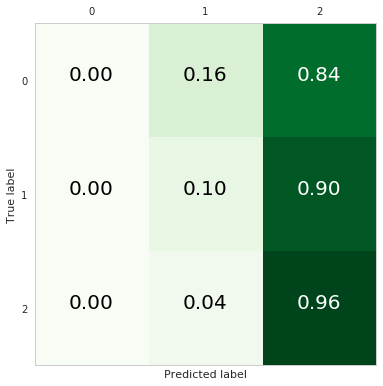

In [23]:
y_pred_mlp_proba = mlp_thin_res.predict_proba(X_test_thin.values)
y_pred_mlp = np.argmax(y_pred_mlp_proba, axis=1)
plot_confusion_matrix(y_test_thin, y_pred_mlp, range(0,num_classes), normalize=True, cmap=plt.cm.Greens)

#### Hyper parameter tuning

In [69]:
weights = []
for i in np.arange(.5, 1, .05):
    for j in np.arange(0.1, 1-i, .05):
        k = 1 - i - j 
        weights.append([i, j, k])

max_ = 512
neurons = []
for i in np.arange(5, max_, 10):
    for j in np.arange(5, max_-i, 10):
        for k in np.arange(5, max_-i-j, 10):
            l = max_ - i - j
            neurons.append([i, j, k, l])
            neurons.append([None, j, k, l])
            neurons.append([i, None, k, l])
            neurons.append([i, j, None, l])
            neurons.append([i, j, k, None])
        
param_grid = {'first_neuron':[5, 10, 50, 100, 512],
              'batch_size': [64], #128, 256, 512
              'neurons': neurons,
              'epochs': [500],
              'dropout_rate': [0, .1, .3], #.4, .5
              'kernel_initializer': ['normal'], #uniform
              'optimizer': ['Nadam', 'Adam'],
              'losses': ['binary_crossentropy'],
              'activation':['relu', 'elu'],
              'class_weight': weights,
              'patience': [10, 50, 100, 200]
            }

In [70]:
# Run the experiment
t = talos.Scan(x=X_res.values,
               y=y_res,
               model=m,
               params=param_grid,
               experiment_name='thin',
               round_limit=10,
               reduction_metric='val_f1score')

 20%|██        | 2/10 [01:01<04:22, 32.78s/it]

Epoch 00056: early stopping


 80%|████████  | 8/10 [06:12<01:46, 53.44s/it]

Epoch 00031: early stopping


100%|██████████| 10/10 [07:11<00:00, 43.19s/it]


In [71]:
a = talos.Analyze(t)
t.data.sort_values(by='val_f1score', ascending=False)

,round_epochs,val_loss,val_accuracy,val_f1score,loss,accuracy,f1score,activation,batch_size,class_weight,dropout_rate,epochs,first_neuron,kernel_initializer,losses,neurons,optimizer,patience
6,100,0.070017,0.984416,0.976807,0.015017,0.994726,0.992134,elu,64,"[0.8500000000000003, 0.1, 0.049999999999999684]",0.1,500,512,normal,binary_crossentropy,"[165, None, 45, 152]",Adam,50
7,100,0.072481,0.983842,0.975951,0.016987,0.994375,0.991608,relu,64,"[0.7000000000000002, 0.1, 0.19999999999999982]",0.1,500,100,normal,binary_crossentropy,"[395, 75, 25, None]",Nadam,200
8,31,0.101280,0.969816,0.954997,0.030459,0.989769,0.984090,relu,64,"[0.55, 0.30000000000000004, 0.1499999999999999]",0.0,500,100,normal,binary_crossentropy,"[15, 315, 175, 182]",Adam,10
3,100,0.174055,0.962434,0.943573,0.022373,0.993391,0.990143,relu,64,"[0.6000000000000001, 0.15000000000000002, 0.24...",0.0,500,10,normal,binary_crossentropy,"[None, 355, 25, 142]",Adam,50
9,100,0.127791,0.952100,0.928417,0.152042,0.939493,0.908779,elu,64,"[0.8000000000000003, 0.15000000000000002, 0.04...",0.3,500,100,normal,binary_crossentropy,"[105, 45, None, 362]",Adam,200
4,100,0.170983,0.937664,0.905475,0.198192,0.920473,0.877635,relu,64,"[0.55, 0.30000000000000004, 0.1499999999999999]",0.1,500,10,normal,binary_crossentropy,"[95, 65, 345, 352]",Adam,100
0,100,0.188707,0.935942,0.903871,0.138912,0.949584,0.924235,elu,64,"[0.7000000000000002, 0.20000000000000004, 0.09...",0.0,500,5,normal,binary_crossentropy,"[85, 85, 295, None]",Adam,50
1,56,0.219149,0.924377,0.885960,0.128735,0.951552,0.926180,elu,64,"[0.6500000000000001, 0.25000000000000006, 0.09...",0.0,500,5,normal,binary_crossentropy,"[165, 285, 55, 62]",Nadam,10
2,100,0.279139,0.877707,0.814379,0.311136,0.857329,0.783507,relu,64,"[0.5, 0.40000000000000013, 0.09999999999999987]",0.3,500,10,normal,binary_crossentropy,"[65, 75, 295, None]",Adam,50
5,100,0.385676,0.838583,0.754758,0.382783,0.835777,0.751558,relu,64,"[0.6500000000000001, 0.30000000000000004, 0.04...",0.3,500,5,normal,binary_crossentropy,"[None, 25, 125, 222]",Adam,50


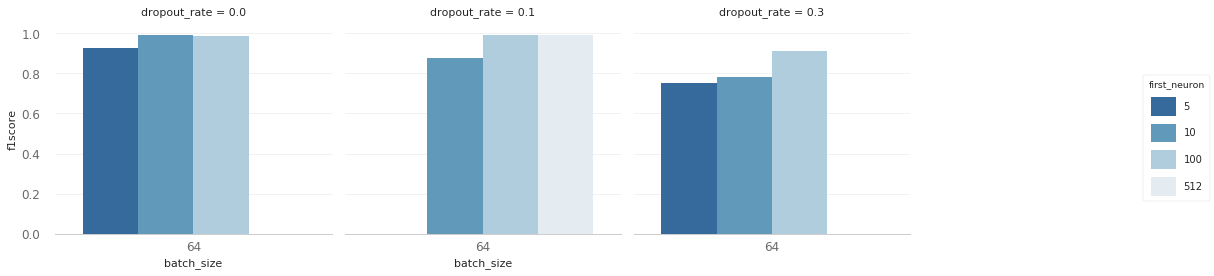

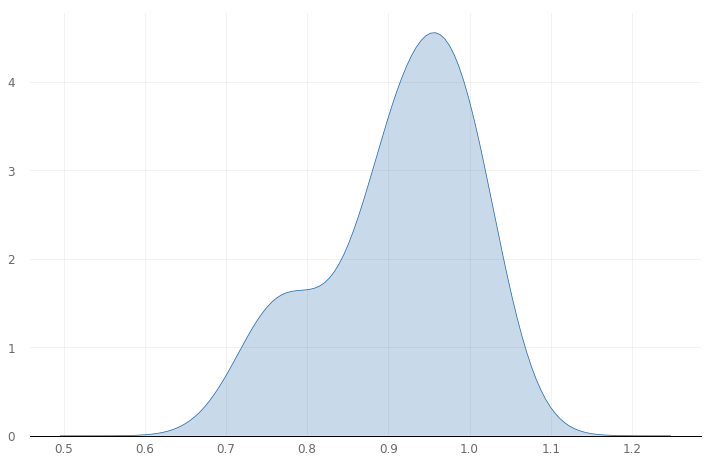

In [72]:
#a.plot_hist('f1score')
#a.plot_regs(x='f1score', y='first_neuron')
#a.plot_box(x='f1score', y='first_neuron')
a.plot_bars('batch_size', 'f1score', 'first_neuron', 'dropout_rate')
a.plot_kde(x='f1score')

In [73]:
bm = t.best_model(metric='val_f1score', asc=False)
print(bm.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               31232     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 165)               84645     
_________________________________________________________________
dropout_2 (Dropout)          (None, 165)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 45)                7470      
_________________________________________________________________
dropout_3 (Dropout)          (None, 45)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 152)              

In [ ]:
from shutil import rmtree
try:
    os.remove('test_deploy.zip')
except FileNotFoundException:
    pass
rmtree('test_deploy')
talos.Deploy(scan_object=t, model_name='test_deploy', metric='val_f1score')
restored = talos.Restore('test_deploy.zip')
print(restored.model.summary())

              precision    recall  f1-score   support

           0       0.92      0.87      0.89      1109
           1       0.07      0.16      0.10        64
           2       0.20      0.13      0.16        62

    accuracy                           0.80      1235
   macro avg       0.40      0.38      0.38      1235
weighted avg       0.84      0.80      0.81      1235



<Figure size 432x288 with 0 Axes>

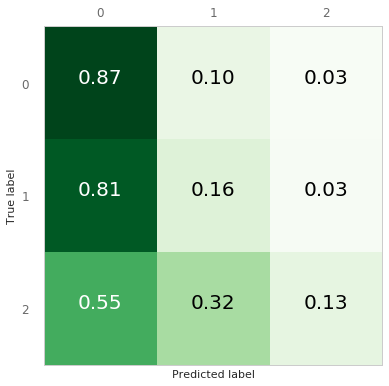

In [74]:
p = talos.Predict(t)
y_pred_proba = p.predict(X_test, metric='val_f1score', asc=False)
y_pred = np.argmax(y_pred_proba, axis=1)
plot_confusion_matrix(y_test, y_pred, range(0,num_classes), normalize=True, cmap=plt.cm.Greens)

In [21]:
print(p)

### Gaussian Processes

#### Pairwise kernel

In [120]:
#kernel = 1.0 * RBF(1.0)
#from sklearn.gaussian_process.kernels import PairwiseKernel
kernel = PairwiseKernel()
gpc = GaussianProcessClassifier(kernel=kernel, n_jobs=-1)

with joblib.parallel_backend('dask'):
    gpc.fit(X_train, y_train)

In [ ]:
y_pred_gpc_proba = gpc.predict_proba(X_test.values)
y_pred_gpc = np.argmax(y_pred_gpc_proba, axis=1)
plot_confusion_matrix(y_test, y_pred_gpc, range(0,4), normalize=True, cmap=plt.cm.Purples)

#### Dotproduct kernel

In [123]:
#kernel = 1.0 * RBF(1.0)
from sklearn.gaussian_process.kernels import DotProduct
kernel = DotProduct()
gpc = GaussianProcessClassifier(kernel=kernel, n_jobs=-1)

with joblib.parallel_backend('dask'):
    gpc.fit(X_train, y_train)

In [ ]:
y_pred_gpc_proba = gpc.predict_proba(X_test.values)
y_pred_gpc = np.argmax(y_pred_gpc_proba, axis=1)
plot_confusion_matrix(y_test, y_pred_gpc, range(0,4), normalize=True, cmap=plt.cm.Purples)

In [ ]:
client = Client()

#### Compound kernel with small data

In [ ]:
kernel = PairwiseKernel(metric='laplacian') *  DotProduct()
gpc_compound = GaussianProcessClassifier(kernel=kernel, n_jobs=-1)

with joblib.parallel_backend('dask'):
    gpc_compound.fit(X_train_small, y_train_small)

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      1109
           1       0.06      0.23      0.09        64
           2       0.33      0.19      0.24        62

    accuracy                           0.72      1235
   macro avg       0.44      0.40      0.40      1235
weighted avg       0.85      0.72      0.78      1235



<Figure size 432x288 with 0 Axes>

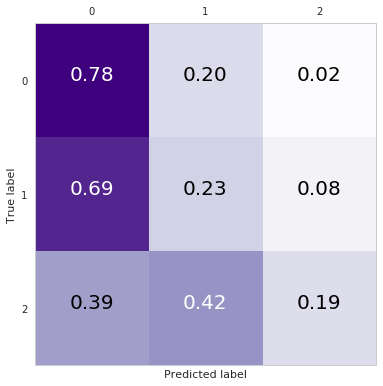

In [39]:
y_pred_gpc_c_proba = gpc_compound.predict_proba(X_test.values)
y_pred_gpc_c = np.argmax(y_pred_gpc_c_proba, axis=1)
plot_confusion_matrix(y_test, y_pred_gpc_c, range(0,num_classes), normalize=True, cmap=plt.cm.Purples)

In [41]:
kernel = PairwiseKernel(metric='laplacian') *  DotProduct() + WhiteKernel()
gpc_compound = GaussianProcessClassifier(kernel=kernel, n_jobs=-1)

with joblib.parallel_backend('dask'):
    gpc_compound.fit(X_train_small, y_train_small)

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      1109
           1       0.06      0.23      0.09        64
           2       0.33      0.19      0.24        62

    accuracy                           0.72      1235
   macro avg       0.44      0.40      0.40      1235
weighted avg       0.85      0.72      0.78      1235



<Figure size 432x288 with 0 Axes>

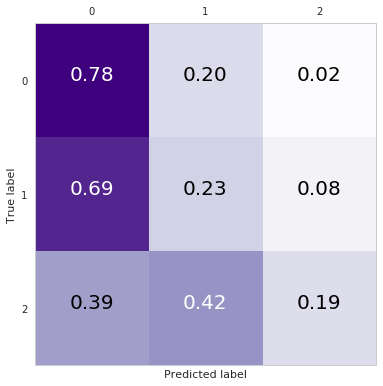

In [42]:
y_pred_gpc_c_proba = gpc_compound.predict_proba(X_test.values)
y_pred_gpc_c = np.argmax(y_pred_gpc_c_proba, axis=1)
plot_confusion_matrix(y_test, y_pred_gpc_c, range(0,num_classes), normalize=True, cmap=plt.cm.Purples)

Average precision score, micro-averaged over all classes: 0.84


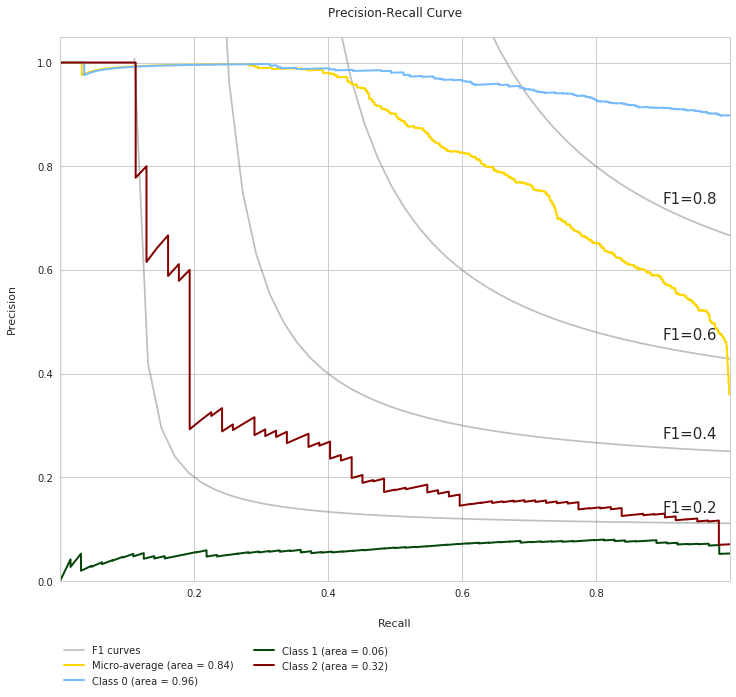

In [40]:
prec_rec_curve(y_test, y_pred_gpc_c_proba, num_classes, fontsize=15)

#### Compound kernel with small SMOTE

In [43]:
kernel = PairwiseKernel(metric='laplacian') *  DotProduct()
gpc_compound = GaussianProcessClassifier(kernel=kernel, n_jobs=-1)
X_res_small, y_res_small = SMOTE().fit_resample(X_train_small, y_train_small)

with joblib.parallel_backend('dask'):
    gpc_compound.fit(X_res_small, y_res_small)

              precision    recall  f1-score   support

           0       0.94      0.71      0.81      1109
           1       0.05      0.25      0.08        64
           2       0.24      0.27      0.25        62

    accuracy                           0.67      1235
   macro avg       0.41      0.41      0.38      1235
weighted avg       0.86      0.67      0.75      1235



<Figure size 432x288 with 0 Axes>

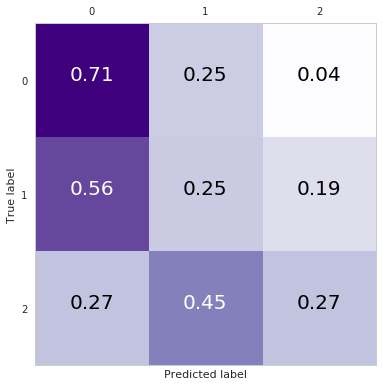

In [44]:
y_pred_gpc_c_proba = gpc_compound.predict_proba(X_test.values)
y_pred_gpc_c = np.argmax(y_pred_gpc_c_proba, axis=1)
plot_confusion_matrix(y_test, y_pred_gpc_c, range(0,num_classes), normalize=True, cmap=plt.cm.Purples)

Average precision score, micro-averaged over all classes: 0.79


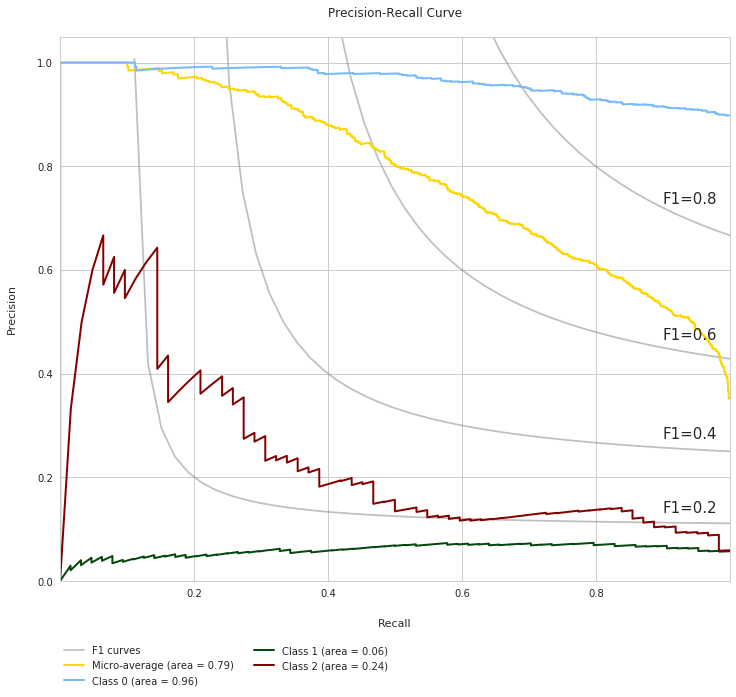

In [45]:
prec_rec_curve(y_test, y_pred_gpc_c_proba, num_classes, fontsize=15)

#### Compound kernel with tiny data

In [102]:
kernel = PairwiseKernel(metric='laplacian') *  DotProduct() + WhiteKernel()
gpc_compound_tiny = GaussianProcessClassifier(kernel=kernel, n_jobs=-1)

with joblib.parallel_backend('dask'):
    gpc_compound_tiny.fit(X_train_tiny, y_train_tiny)

              precision    recall  f1-score   support

           0       0.91      0.62      0.74       460
           1       0.10      0.44      0.17        45
           2       0.38      0.33      0.35        54

    accuracy                           0.58       559
   macro avg       0.46      0.47      0.42       559
weighted avg       0.79      0.58      0.66       559



<Figure size 432x288 with 0 Axes>

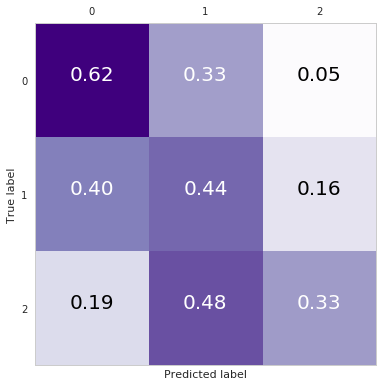

In [103]:
y_pred_gpc_c_proba = gpc_compound_tiny.predict_proba(X_test.values)
y_pred_gpc_c = np.argmax(y_pred_gpc_c_proba, axis=1)
plot_confusion_matrix(y_test, y_pred_gpc_c, range(0,num_classes), normalize=True, cmap=plt.cm.Purples)

Average precision score, micro-averaged over all classes: 0.68


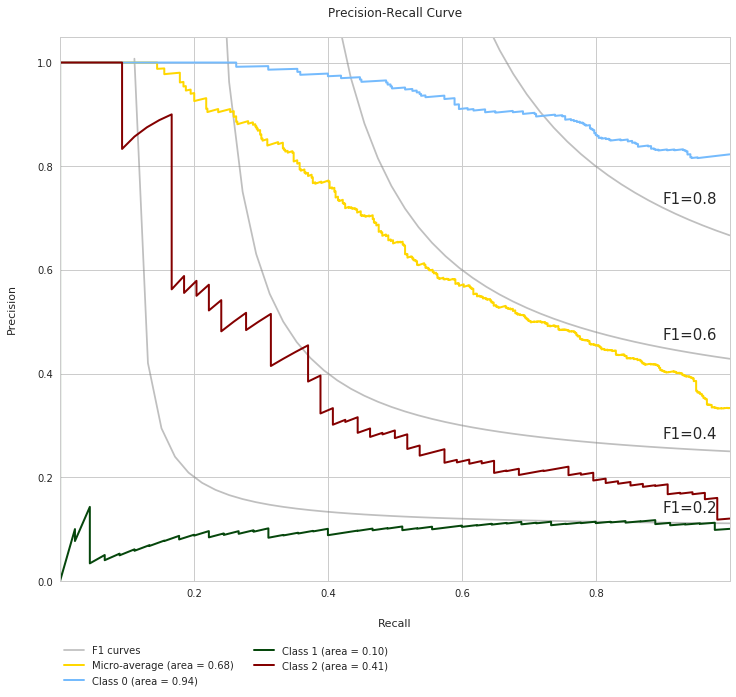

In [104]:
prec_rec_curve(y_test, y_pred_gpc_c_proba, num_classes, fontsize=15)

#### Grid-search for distance metric in compund kernel

In [ ]:
#param_grid = {'kernel__k1__metric': ['linear','poly','polynomial','rbf','laplacian','sigmoid','cosine']}
param_grid = {'kernel__k1__metric': ['linear','poly','polynomial','rbf','laplacian','cosine']}

client.restart()
#param_grid = {'kernel__k1__metric': ['sigmoid']}

kernel = PairwiseKernel() *  DotProduct()
gpc_compound2 = GaussianProcessClassifier(kernel=kernel, n_jobs=-1)

gpc_compound2, cv_results = gridcv(gpc_compound2, param_grid, X_train_tiny, y_train_tiny)
              
y_pred_gpc_c_proba = gpc_compound2.predict_proba(X_test.values)
y_pred_gpc_c = np.argmax(y_pred_gpc_c_proba, axis=1)
plot_confusion_matrix(y_test, y_pred_gpc_c, range(0,4), normalize=True, cmap=plt.cm.Purples)

Second best:

In [ ]:
kernel = PairwiseKernel(metric='cosine') *  DotProduct()
gpc_compound = GaussianProcessClassifier(kernel=kernel, n_jobs=-1)

with joblib.parallel_backend('dask'):
    gpc_compound.fit(X_train_tiny, y_train_tiny)
    
y_pred_gpc_c_proba = gpc_compound.predict_proba(X_test.values)
y_pred_gpc_c = np.argmax(y_pred_gpc_c_proba, axis=1)
plot_confusion_matrix(y_test, y_pred_gpc_c, range(0,4), normalize=True, cmap=plt.cm.Purples)

#### Compound kernel with full data

In [ ]:
kernel = PairwiseKernel(metric='laplacian') *  DotProduct()
gpc_compound = GaussianProcessClassifier(kernel=kernel, n_jobs=-1)

with joblib.parallel_backend('dask'):
    gpc_compound.fit(X_train, y_train)

In [ ]:
y_pred_gpc_c_proba = gpc_compound.predict_proba(X_test.values)
y_pred_gpc_c = np.argmax(y_pred_gpc_c_proba, axis=1)
plot_confusion_matrix(y_test, y_pred_gpc_c, range(0,num_classes), normalize=True, cmap=plt.cm.Purples)

In [ ]:
prec_rec_curve(y_test, y_pred_gpc_c_proba, num_classes, fontsize=15)

#### Compound kernel with thin data

In [ ]:
kernel = PairwiseKernel() * DotProduct() + WhiteKernel()
gpc_thin = GaussianProcessClassifier(kernel=kernel, n_jobs=-1)

with joblib.parallel_backend('dask'):
    gpc_thin.fit(X_train_thin, y_train_thin)

In [ ]:
y_pred_gpc_thin_proba = gpc_thin.predict_proba(X_test_thin.values)
y_pred_gpc_thin = np.argmax(y_pred_gpc_thin_proba, axis=1)
plot_confusion_matrix(y_test_thin, y_pred_gpc_thin, range(0,num_classes), normalize=True, cmap=plt.cm.Greens)

### VAE

Used example: https://radicalrafi.github.io/posts/autoencoders-as-classifiers/

Other resources: 
- https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py

In [197]:
X_vae, y_vae, X_vae_res, y_vae_res, X_vae_test, y_vae_test = get_data('../data/classification_dataset_loiste_jse_forest.csv', options, scaler=MinMaxScaler(feature_range=(-1,1)))

In [213]:
input_ = Input(shape=(n_params,))
encoded = Dense(512, activation='relu')(input_)
encoded = Dense(256, activation='relu')(encoded)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded) #the latent layer 

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(n_params, activation='sigmoid')(decoded)

autoencoder = Model(input_, decoded)
autoencoder.compile(optimizer='adadelta', loss='mse')

autoencoder.summary()

autoencoder.fit(X_vae_res, X_vae_res,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_vae_test, X_vae_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 58)                0         
_________________________________________________________________
dense_145 (Dense)            (None, 512)               30208     
_________________________________________________________________
dense_146 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_147 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_148 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_149 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_150 (Dense)            (None, 16)                528       
__________

In [214]:
y_train_one_hot = label_binarize(y_train, classes=np.arange(4))
y_res_one_hot = label_binarize(y_res, classes=np.arange(4))
y_test_one_hot = label_binarize(y_test, classes=np.arange(4))

output = Dense(4, activation='softmax')(encoded)
autoencoder = Model(input_, output)
autoencoder.compile(optimizer='adadelta',loss='categorical_crossentropy',metrics=['accuracy'])
autoencoder.fit(X_res, y_res_one_hot, epochs=5, batch_size=32)
score = autoencoder.evaluate(X_test, y_test_one_hot, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/5
18240/18240 [==============================] - 5s 280us/step - loss: 0.6711 - acc: 0.7302
Epoch 2/5
18240/18240 [==============================] - 3s 187us/step - loss: 0.4180 - acc: 0.8464
Epoch 3/5
18240/18240 [==============================] - 3s 190us/step - loss: 0.3435 - acc: 0.8842
Epoch 4/5
18240/18240 [==============================] - 3s 187us/step - loss: 0.3022 - acc: 0.9021
Epoch 5/5
18240/18240 [==============================] - 3s 187us/step - loss: 0.2755 - acc: 0.9162
Test loss: 0.8015463395746882
Test accuracy: 0.7143712575564127


<Figure size 432x288 with 0 Axes>

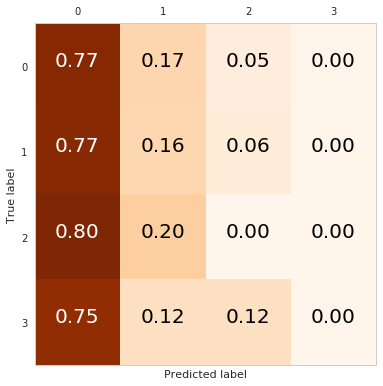

In [216]:
y_pred_proba_vae = autoencoder.predict(X_test)
y_pred_vae = np.argmax(y_pred_proba_vae, axis=1)
plot_confusion_matrix(y_test, y_pred_vae, range(0,4), normalize=True, cmap=plt.cm.Oranges)

### Two-phase approach

Prepare data

In [132]:
class_weights = []
for i in np.arange(0,1,.3):
    k = 1 - i
    class_weights.append({0: i, 1: j})

param_grid_rfc_bin = {"n_estimators": [10, 100, 150, 200, 250, 500],
                  "max_depth": [3, 10, 20, 50, None],
                  "max_features": ["auto", "sqrt", "log2", None],
                  "min_samples_split": [2,5,10,50],
                  "min_samples_leaf": [1, 2, 4, 10, 20],
                  "bootstrap": [True, False],
                  "class_weight": class_weights}


In [140]:
X1 = X_res_thin_random
y1 = y_res_thin_random.copy()
y1[(y1>0)] = 1

model1, cv_results = cv(RandomForestClassifier(n_jobs=-1), param_grid_rfc_bin, X1, y1, n_iter=100)

..performing cv search...
                                              params  mean_fit_time  \
0  {'n_estimators': 100, 'min_samples_split': 5, ...      16.351580   
1  {'n_estimators': 150, 'min_samples_split': 10,...      27.198649   
2  {'n_estimators': 100, 'min_samples_split': 10,...      16.889858   
3  {'n_estimators': 250, 'min_samples_split': 10,...      45.315759   
4  {'n_estimators': 100, 'min_samples_split': 2, ...      17.933456   

   std_fit_time  mean_score_time  std_score_time  split0_test_f1_macro  \
0      0.429885         0.212970        0.079448              0.950521   
1      2.504220         0.275801        0.119425              0.938072   
2      0.570256         0.242776        0.031945              0.933851   
3      1.445034         0.591385        0.079500              0.936093   
4      0.418403         0.231242        0.091186              0.932952   

   split1_test_f1_macro  split2_test_f1_macro  split3_test_f1_macro  \
0              0.977051        

NameError: name 'yt1_' is not defined

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1125
           1       0.58      0.39      0.47       107

    accuracy                           0.92      1232
   macro avg       0.76      0.68      0.71      1232
weighted avg       0.91      0.92      0.92      1232



<Figure size 432x288 with 0 Axes>

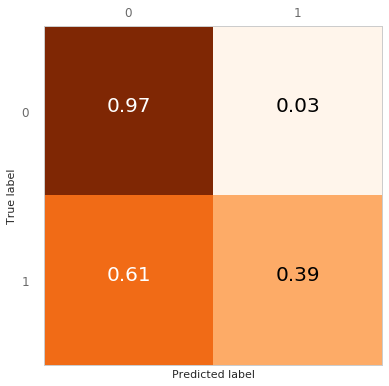

In [141]:
Xt1_ = X_test_thin_random
yt1_ = y_test_thin_random.copy()
yt1_[(yt1_>0)] = 1

plot_confusion_matrix(yt1_, model1.predict(Xt1_), range(0,2), normalize=True, cmap=plt.cm.Oranges)

Alternative model for the 1st phase

In [155]:
model1_svc = SVC().fit(X1, y1)

              precision    recall  f1-score   support

           0       0.97      0.78      0.86      1125
           1       0.24      0.72      0.36       107

    accuracy                           0.78      1232
   macro avg       0.60      0.75      0.61      1232
weighted avg       0.90      0.78      0.82      1232



<Figure size 432x288 with 0 Axes>

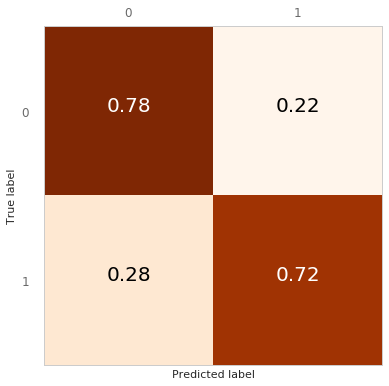

In [156]:
plot_confusion_matrix(yt1_, model1_svc.predict(Xt1_), range(0,2), normalize=True, cmap=plt.cm.Oranges)

Phase 2:

              precision    recall  f1-score   support

           1       0.84      0.66      0.74        71
           2       0.53      0.75      0.62        36

    accuracy                           0.69       107
   macro avg       0.68      0.71      0.68       107
weighted avg       0.74      0.69      0.70       107



<Figure size 432x288 with 0 Axes>

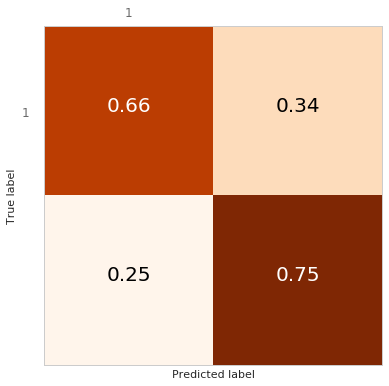

In [143]:
X2 = X_res_thin_random[(y_res_thin_random > 0)]
y2 = y_res_thin_random[(y_res_thin_random > 0)]

model2 = SVC(kernel=DotProduct() + WhiteKernel()).fit(X2, y2)

Xt2_ = X_test_thin_random[(y_test_thin_random > 0)]
yt2_ = y_test_thin_random[(y_test_thin_random > 0)]

plot_confusion_matrix(yt2_, model2.predict(Xt2_), range(1,2), normalize=True, cmap=plt.cm.Oranges)

Prediction with alternative 1

In [161]:
yp1_ = model1.predict(X_test_thin_random)

Xp2_ = X_test_thin_random[(yp1_>0)]

yp2_ = model2.predict(Xp2_)
yp1_[(yp1_ > 0)] = yp2_

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1125
           1       0.35      0.15      0.22        71
           2       0.40      0.47      0.44        36

    accuracy                           0.91      1232
   macro avg       0.57      0.53      0.54      1232
weighted avg       0.89      0.91      0.90      1232



<Figure size 432x288 with 0 Axes>

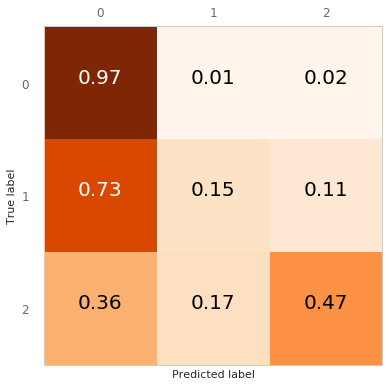

In [162]:
plot_confusion_matrix(y_test_thin_random, yp1_, range(0,num_classes), normalize=True, cmap=plt.cm.Oranges)

Prediction with alternative (random testset) 2

In [157]:
yp1_ = model1_svc.predict(X_test_thin_random)

Xp2_ = X_test_thin_random[(yp1_>0)]

yp2_ = model2.predict(Xp2_)
yp1_[(yp1_ > 0)] = yp2_

              precision    recall  f1-score   support

           0       0.97      0.78      0.86      1125
           1       0.16      0.42      0.23        71
           2       0.20      0.72      0.31        36

    accuracy                           0.76      1232
   macro avg       0.44      0.64      0.47      1232
weighted avg       0.90      0.76      0.81      1232



<Figure size 432x288 with 0 Axes>

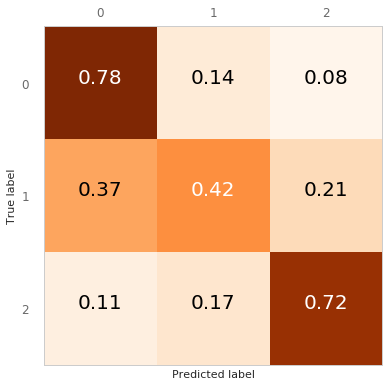

In [159]:
plot_confusion_matrix(y_test_thin_random, yp1_, range(0,num_classes), normalize=True, cmap=plt.cm.Oranges)

Prediction with alternative 2 (fixed testset)

In [168]:
yp1_ = model1_svc.predict(X_test_thin)

Xp2_ = X_test_thin[(yp1_>0)]

yp2_ = model2.predict(Xp2_)
yp1_[(yp1_ > 0)] = yp2_

              precision    recall  f1-score   support

           0       0.99      0.80      0.89      1109
           1       0.19      0.50      0.27        64
           2       0.30      0.79      0.43        62

    accuracy                           0.79      1235
   macro avg       0.49      0.70      0.53      1235
weighted avg       0.91      0.79      0.83      1235



<Figure size 432x288 with 0 Axes>

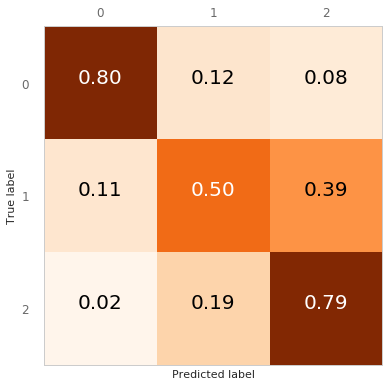

In [169]:
plot_confusion_matrix(y_test_thin, yp1_, range(0,num_classes), normalize=True, cmap=plt.cm.Oranges)